# ODE System Identification with Monotonic Splines

The proposed method aims at a substantial speedup in exploring the fitness of large systems of ODEs w.r.t. provided full or partial data of variables' trajectories. These ODE systems are often found in physical and biochemical simulations. It is not feasible to expect a perfect qualitative match of a real physical system to its model variables' traces. Therefore, by exploring the fitness we mean the study of a Pareto-frontier in a space of per-variable fitness. Thus, as we are still aiming to attain the best fitness possible, we admit that, in general, we'll need to explore a top-K best fits of parameters w.r.t. the "closeness" of trajectories to the real data. The exploring may show that some variables are generally harder to fit than the others, which could yield improvements in the ODE model under study.

Preliminarily, the proposed method shows a possibility of attaining a representative sample of the referred Pareto-frontier with orders of magnitude fewer iterations, compute and time, as compared to a conventional approach of incorporating the solving of the ODE system along the calls of a fitness criterion being optimize

We are aware of the prior art in the area of dynamical systems parameter estimation, including the implementation in GEKKO library. For various reasons we could not obrain reliable operation of these implementations in our practice and given the size and complexity of operated ODE systems. We plan to pay more attention to comparing the prior art to proposed methods.d.

_Copyright (c) 2024: Dan Skaov_



In [1]:
# [1]
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.interpolate import PchipInterpolator, UnivariateSpline
from scipy.optimize import minimize, least_squares, Bounds
from scipy.integrate import solve_ivp
from typing import List
import random
import math
import pandas as pd;
from numba import jit
from itertools import combinations
from queue import PriorityQueue

C:\Users\x1\AppData\Local\Temp\ipykernel_42228\3737723733.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd;


## Parameters and settings

In [2]:
## Selection of fitness function: 'rmse' or 'mape'
OBJECTIVE_FUNCTION_TYPE = 'mape'

# Number of points in t-grid for spline derivative estimation
NUM_DERIVATIVE_POINTS = 30

# Number of t-points for plotting ODE solutions
NUM_PLOTTING_POINTS = 15

# Noise level for data trajectory
NOISE_LEVEL = 0.05

# Number of random starting points for optimization
NUM_RANDOM_STARTS = 10

# Timeout for each optimization in seconds
TIMEOUT = 10.0

# Spline type: 'pchip' or 'smooth'
SPLINE_TYPE = 'pchip'

# Smoothing factor for UnivariateSpline (only used if SPLINE_TYPE is 'smooth')
SMOOTHING_FACTOR = 0.1

# Number of fixed variables for combinatorial optimization
NUM_FIXED_VARIABLES = 5

# Number of beam search outer loops
NUM_BEAM_OUTER_LOOPS = NUM_RANDOM_STARTS

# Beam search top K
BEAM_TOP_K = 5

# Include combinations for variable counts
INCLUDE_COMBINATIONS = [0, 0, 0, 0, 1, 0, 0]

In [3]:
# [2]
# Parameters
true_params = [2.5, 100.0, 6.0, 16.0, 100.0, 1.28, 12.0, 1.8, 13.0, 4.0, 0.52, 0.1, 1.0, 4.0]
param_names = ['J0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k', 'K', 'q', 'K1', 'psi', 'N_', 'A']

# Initial conditions
true_initial_conditions = [0.40, 1.50, 0.14, 0.20, 0.20, 1.00, 0.07]
variable_names = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']

# Time points for simulation
t_start = 0.0
t_end = 1.0
t_points = np.linspace(t_start, t_end, NUM_PLOTTING_POINTS)

In [4]:
# [3]
# Define the ODE function in Python
@jit(nopython=True)
def yeast_ode(t, S, P):
    S1, S2, S3, S4, S5, S6, S7 = S
    J0, k1, k2, k3, k4, k5, k6, k, K, q, K1, psi, N_, A = P
    dS1 = J0 - k1*S1*S6/(1+(S6/K1)**4)
    dS2 = 2*k1*S1*S6/(1+(S6/K1)**4) - k2*S2*(N_-S5) - k6*S2*S5
    dS3 = k2*S2*(N_-S5) - k3*S3*(A-S6)
    dS4 = k3*S3*(A-S6) - k4*S4*S5 - K*(S4-S7)
    dS5 = k2*S2*(N_-S5) - k4*S4*S5 - k6*S2*S5
    dS6 = -2*k1*S1*S6/(1+(S6/K1)**4) + 2*k3*S3*(A-S6) - k5*S6
    dS7 = psi*K*(S4-S7) - k*S7
    return [dS1, dS2, dS3, dS4, dS5, dS6, dS7]

In [5]:
# [4]
# Solve the ODE problem to get the 'true' trajectory
def yeast_ode_wrapper(t, S):
    return yeast_ode(t, S, true_params)

sol = solve_ivp(yeast_ode_wrapper, [t_start, t_end], true_initial_conditions, t_eval=t_points, method='LSODA')
true_solution = sol.y.T  # Shape: (len(t_points), num_variables)

In [6]:
# [5]
# Generate 'data' trajectory
data_solution = true_solution.copy()

# Flip the first and third variables upside down
data_solution[:, 0] = np.max(data_solution[:, 0]) - data_solution[:, 0] + np.min(data_solution[:, 0])
data_solution[:, 2] = np.max(data_solution[:, 2]) - data_solution[:, 2] + np.min(data_solution[:, 2])

# Add small noise to other variables (excluding first and third)
for i in range(data_solution.shape[1]):
    if i not in [0, 2]:
        noise = NOISE_LEVEL * np.random.randn(len(t_points)) * np.abs(data_solution[:, i])
        data_solution[:, i] += noise

# Create splines for each variable
splines = []
for i in range(data_solution.shape[1]):
    if SPLINE_TYPE == 'pchip':
        spline = PchipInterpolator(t_points, data_solution[:, i])
    elif SPLINE_TYPE == 'smooth':
        spline = UnivariateSpline(t_points, data_solution[:, i], s=SMOOTHING_FACTOR)
    else:
        raise ValueError("Invalid SPLINE_TYPE. Choose 'pchip' or 'smooth'.")
    splines.append(spline)

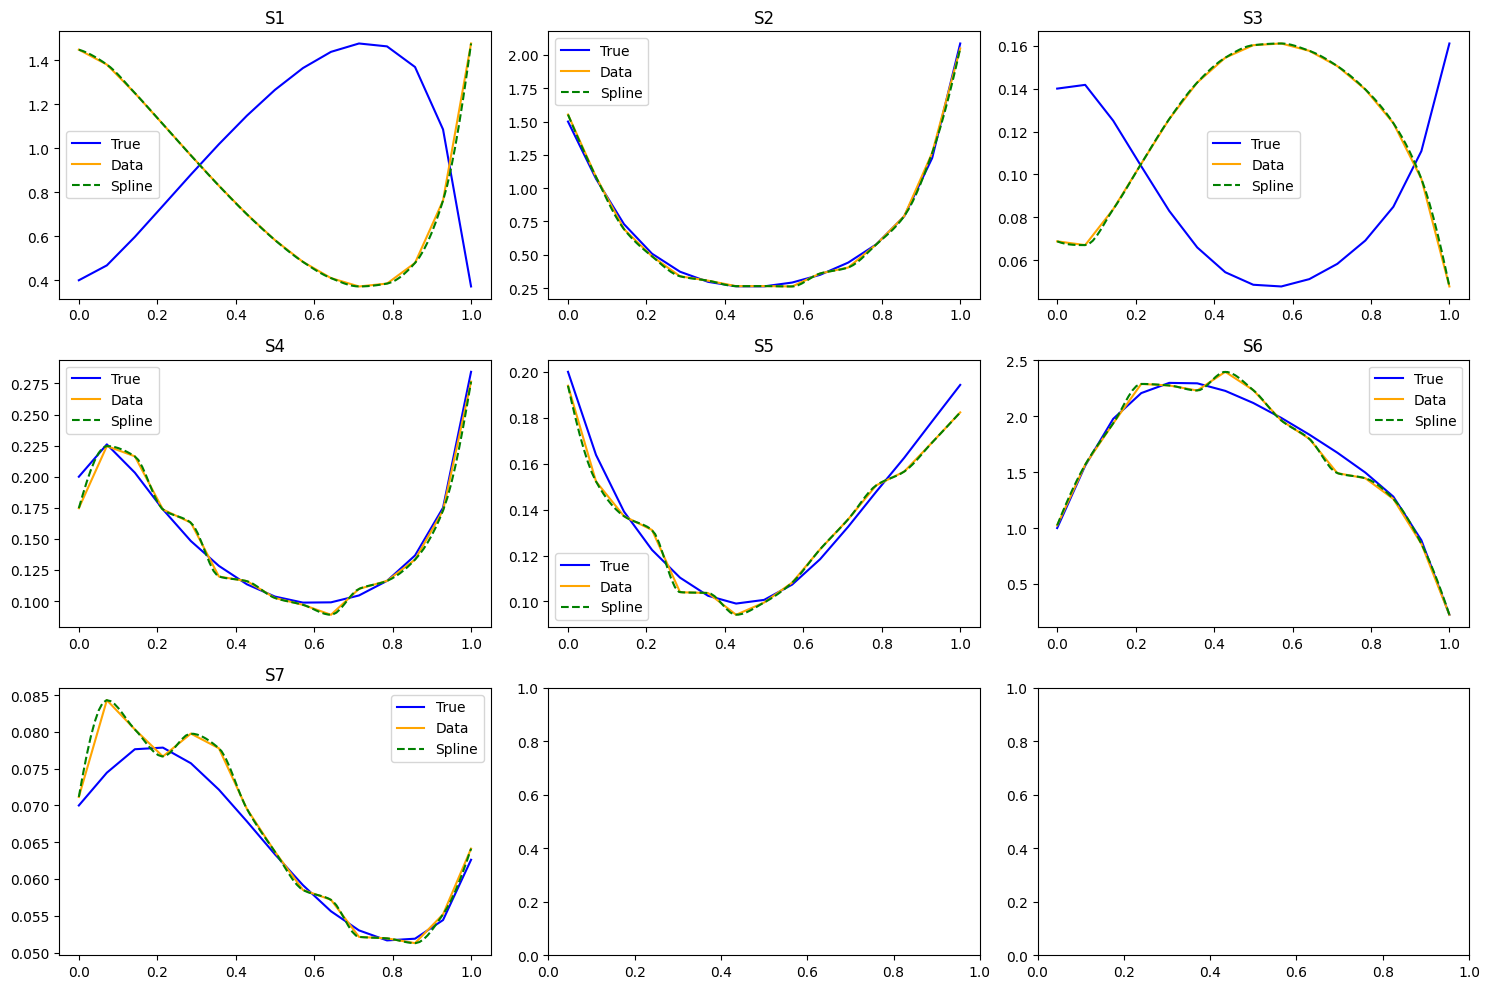

In [7]:
# [6]
# Plot the 'true' and 'data' trajectories, along with splines
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes[:7]):
    ax.plot(t_points, true_solution[:, i], label='True', color='blue')
    ax.plot(t_points, data_solution[:, i], label='Data', color='orange')
    
    # Plot spline
    t_spline = np.linspace(t_start, t_end, 100)
    ax.plot(t_spline, splines[i](t_spline), label='Spline', color='green', linestyle='--')
    
    ax.set_title(variable_names[i])
    ax.legend()

fig.tight_layout()
plt.show()

In [8]:
# [7]
# Define the ObjectiveFunction class
class ObjectiveFunction:
    def __init__(self, ode_system, data_solution, t_points, num_variables, objective_function_type=OBJECTIVE_FUNCTION_TYPE, timeout=TIMEOUT, lower_bounds=None, upper_bounds=None):
        self.ode_system = ode_system
        self.data_solution = data_solution
        self.t_points = t_points
        self.num_variables = num_variables
        self.objective_function_type = objective_function_type
        self.func_values = []
        self.per_variable_distances = []
        self.iterations = 0
        self.start_time = time.time()
        self.timeout = timeout
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.alpha = np.ones(num_variables)  # Default alpha values

    def __call__(self, params, alpha=None):
        if alpha is not None:
            self.alpha = alpha

        if time.time() - self.start_time > self.timeout:
            return self.func_values[-1] if self.func_values else np.inf

        # Check if params are within bounds
        if self.lower_bounds is not None and np.any(params < self.lower_bounds):
            return np.inf
        if self.upper_bounds is not None and np.any(params > self.upper_bounds):
            return np.inf

        self.iterations += 1
        num_initial_conditions = self.num_variables
        initial_conditions = params[:num_initial_conditions]
        ode_params = params[num_initial_conditions:]

        # Solve the ODE system
        try:
            def ode_system(t, S):
                return self.ode_system(t, S, ode_params)

            sol = solve_ivp(ode_system, [self.t_points[0], self.t_points[-1]], initial_conditions, t_eval=self.t_points, method='LSODA')
            if not sol.success:
                return np.inf
            model_solution = sol.y.T  # Shape: (len(t_points), num_variables)
        except Exception as e:
            # If the ODE solver fails, return a high objective value
            return np.inf

        # Compute per-variable distances
        per_variable_distance = []
        for i in range(self.num_variables):
            if self.alpha[i] == 0:
                per_variable_distance.append(0)
                continue

            data_seq = self.data_solution[:, i]
            model_seq = model_solution[:, i]

            # Scale data_seq to [0,1], per variable
            data_min = data_seq.min()
            data_max = data_seq.max()
            if data_max - data_min == 0:
                data_scaled = np.zeros_like(data_seq)
                model_scaled = np.zeros_like(model_seq)
            else:
                data_scaled = (data_seq - data_min) / (data_max - data_min)
                model_scaled = (model_seq - data_min) / (data_max - data_min)

            if self.objective_function_type == 'rmse':
                distance = np.sqrt(np.mean(((data_scaled - model_scaled) ** 2) / len(t_grid)))
                distance /= list(self.alpha).count(1)
            elif self.objective_function_type == 'mape':
                distance = np.mean(np.abs((data_scaled - model_scaled) / (data_scaled + 1.0)) / len(t_grid))
                distance /= list(self.alpha).count(1)
            else:
                raise ValueError("Invalid objective_function_type. Choose 'rmse' or 'mape'.")

            
          
            per_variable_distance.append(distance)

        objective_value = np.sum(np.array(per_variable_distance) * self.alpha)
        self.func_values.append(objective_value)
        self.per_variable_distances.append(per_variable_distance)
        return objective_value

In [9]:
# [8]
# Function to plot trajectories
def plot_fit(result, method_name, fit_idx):
    x = result['x']
    initial_conditions = x[:len(true_initial_conditions)]
    ode_params = x[len(true_initial_conditions):]

    # Solve the ODE system
    def ode_system(t, S):
        return yeast_ode(t, S, ode_params)

    sol = solve_ivp(ode_system, [t_start, t_end], initial_conditions, t_eval=t_points, method='LSODA')
    model_solution = sol.y.T  # Shape: (len(t_points), num_variables)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    axes = axes.flatten()

    for i, ax in enumerate(axes[:7]):
        ax.plot(t_points, model_solution[:, i], label='Fitted', color='red')
        ax.plot(t_points, true_solution[:, i], label='True', color='blue')
        ax.plot(t_points, data_solution[:, i], label='Data', color='orange')
        ax.set_title(variable_names[i])
        ax.legend()

    fig.suptitle(f'{method_name} - Fit {fit_idx+1}', fontsize=16)
    plt.tight_layout()
    plt.show()


## Classical method: Parameter estimation using Nelder-Mead optimization starting from random points

In [ ]:
# [9]
# Classical method
num_params = len(true_initial_conditions) + len(true_params)
param_bounds = []
for i in range(num_params):
    if i < len(true_initial_conditions):
        # For initial conditions
        val = true_initial_conditions[i]
    else:
        # For parameters
        val = true_params[i - len(true_initial_conditions)]
    lower = 0.1 * val
    upper = 10 * val
    param_bounds.append((lower, upper))

# No bounds for Nelder-Mead, but we can check bounds in the ObjectiveFunction
lower_bounds = np.array([b[0] for b in param_bounds])
upper_bounds = np.array([b[1] for b in param_bounds])

results = []

print("Starting Classical Method Optimization...")
start_time = time.time()
for idx in range(NUM_RANDOM_STARTS):
    # Generate random starting point in the hypercube
    x0 = [random.uniform(b[0], b[1]) for b in param_bounds]

    # Create an instance of the ObjectiveFunction
    obj_func = ObjectiveFunction(yeast_ode, data_solution, t_points, num_variables=len(variable_names), lower_bounds=lower_bounds, upper_bounds=upper_bounds)

    try:
        res = minimize(obj_func, x0, method='Nelder-Mead', options={'maxiter': 1000})
        results.append({
            'x': res.x,
            'fun': res.fun,
            'per_variable_distances': obj_func.per_variable_distances[-1]
        })
        print(f"Iteration {idx+1}/{NUM_RANDOM_STARTS}: Objective Value = {res.fun}")
    except TimeoutError:
        print(f"Iteration {idx+1}/{NUM_RANDOM_STARTS}: Timeout")
        last_observed_minimum = obj_func.func_values[-1] if obj_func.func_values else np.inf
        last_observed_argument = x0
        results.append({
            'x': last_observed_argument,
            'fun': last_observed_minimum,
            'per_variable_distances': obj_func.per_variable_distances[-1] if obj_func.per_variable_distances else [np.inf] * len(variable_names)
        })
end_time = time.time()
classical_method_time = (end_time - start_time) / 60  # Convert to minutes
print(f"Classical Method Optimization Completed in {classical_method_time:.2f} minutes.")

In [11]:
# [10]
# Sort the results by objective function value
sorted_results = sorted(results, key=lambda x: x['fun'])

# Plot the top 5 fits
for idx, result in enumerate(sorted_results[:5]):
    plot_fit(result, 'Classical Method', idx)

## Innovative method: Using PCHIP splines and derivative estimation to set up nonlinear equations

In [12]:
# [11]
# Innovative method
# Number of points for derivative estimation
t_grid = np.linspace(t_start, t_end, NUM_DERIVATIVE_POINTS)

# Prepare the data for the nonlinear system
derivatives = []
variable_values = []

for t in t_grid:
    vars_at_t = []
    derivs_at_t = []
    for spline in splines:
        vars_at_t.append(spline(t))
        derivs_at_t.append(spline.derivative()(t))
    variable_values.append(vars_at_t)
    derivatives.append(derivs_at_t)

variable_values = np.array(variable_values)  # Shape: (num_t_points, num_variables)
derivatives = np.array(derivatives)  # Shape: (num_t_points, num_variables)

In [13]:
# [13]
# Calculate the normalization factors for each equation
def calculate_spread():
    spreads = []
    for i in range(len(t_grid)):
        S = variable_values[i]
        dS_dt = derivatives[i]
        spreads.append(dS_dt)
    spreads = np.array(spreads)
    return np.min(spreads, axis=0), np.max(spreads, axis=0)

drv_min, drv_max = calculate_spread()

def residuals_function(P, alpha):
    residuals = []
    for i in range(len(t_grid)):
        S = variable_values[i]
        dS_dt = derivatives[i]
        f_S_P = yeast_ode(0, S, P)
        dS_dt_scaled = (dS_dt - drv_min) / (drv_max - drv_min)
        f_S_P_scaled = (f_S_P - drv_min) / (drv_max - drv_min)
        residual = (dS_dt_scaled - f_S_P_scaled) * alpha / math.sqrt(len(t_grid) * alpha.count(1))
        residuals.extend(residual)
    residuals = np.array(residuals)
    return residuals

# Bounds for parameters
param_bounds = []
for i in range(len(true_params)):
    val = true_params[i]
    lower = 0.1 * val
    upper = 10 * val
    param_bounds.append((lower, upper))

param_bounds = ([b[0] for b in param_bounds], [b[1] for b in param_bounds])

# Get initial conditions from spline at t=0
initial_conditions_innovative = []
for spline in splines:
    initial_conditions_innovative.append(spline(t_start))

In [14]:
# [14]
from collections import defaultdict
import itertools

# Evaluate fitness for the innovative method
print("Starting Innovative Method Optimization...")
start_time = time.time()

# Multimap-like structure for beam search
beam_multimap = defaultdict(list)
EPS = 1e-5
PICK_SIMILAR = 5

for outer_loop in range(NUM_BEAM_OUTER_LOOPS):
    for variable_count in range(len(INCLUDE_COMBINATIONS)):
        if INCLUDE_COMBINATIONS[variable_count] == 1:
            alpha_combinations = list(combinations(range(len(variable_names)), variable_count + 1))

            for combo in alpha_combinations:
                alpha = tuple([1 if i in combo else 0 for i in range(len(variable_names))])

                P0 = [random.uniform(0.1 * val, 10 * val) for val in true_params]
                
                try:
                    res = least_squares(residuals_function, P0, bounds=param_bounds, args=(alpha,))
                    
                    ode_params = res.x
                    initial_conditions = initial_conditions_innovative

                    def ode_system(t, S):
                        return yeast_ode(t, S, ode_params)

                    sol = solve_ivp(ode_system, [t_start, t_end], initial_conditions, t_eval=t_points, method='LSODA')
                    if not sol.success:
                        continue
                    model_solution = sol.y.T

                    obj_func = ObjectiveFunction(yeast_ode, data_solution, t_points, num_variables=len(variable_names))
                    fun_value = obj_func(np.concatenate([initial_conditions, ode_params]), alpha)

                    print(f"For {alpha} got derv={res.cost} and obj={fun_value}")
                  
                    # Add to beam_multimap
                    key = (round(res.cost / EPS) * EPS, alpha)
                    beam_multimap[key].append({
                        'parameters': ode_params,
                        'fun': fun_value
                    })

                except Exception as e:
                    print(f"Exception occurred for alpha {alpha}: {str(e)}")
                    continue

end_time = time.time()
innovative_method_time = (end_time - start_time) / 60
print(f"Innovative Method Optimization Completed in {innovative_method_time:.2f} minutes.")

# Output the contents of the beam multimap
innovative_results = []
for (deriv_fit, alpha), param_list in sorted(beam_multimap.items())[:BEAM_TOP_K]:
    for param_dict in param_list[:PICK_SIMILAR]:
        innovative_results.append({
            'derivatives_fit': deriv_fit,
            'alpha': alpha,
            'parameters': param_dict['parameters'],
            'fun': param_dict['fun']
        })

innovative_df = pd.DataFrame(innovative_results)
print("Top results from Innovative Method:")
display(innovative_df)

Starting Innovative Method Optimization...
For (1, 1, 1, 1, 1, 0, 0) got derv=0.02606043932907811 and obj=0.012049567018498764
For (1, 1, 1, 1, 0, 1, 0) got derv=0.024712265959706048 and obj=0.012490621815735565
For (1, 1, 1, 1, 0, 0, 1) got derv=0.021832806117025306 and obj=0.014059796291981789
For (1, 1, 1, 0, 1, 1, 0) got derv=0.027451839169248017 and obj=0.013060128844763628
For (1, 1, 1, 0, 1, 0, 1) got derv=0.024528133367629015 and obj=0.014330079890196802
For (1, 1, 1, 0, 0, 1, 1) got derv=0.02178719201399409 and obj=0.018369254952497374
For (1, 1, 0, 1, 1, 1, 0) got derv=0.027736380696310636 and obj=0.013355905571833738
For (1, 1, 0, 1, 1, 0, 1) got derv=0.024372353832916558 and obj=0.014803819772832506
For (1, 1, 0, 1, 0, 1, 1) got derv=0.024719257157312245 and obj=0.013440476362078384
For (1, 1, 0, 0, 1, 1, 1) got derv=0.025090046472197928 and obj=0.018181030269420334
For (1, 0, 1, 1, 1, 1, 0) got derv=0.027478810790815815 and obj=0.00950806173169403
For (1, 0, 1, 1, 1, 0, 1)

derivatives_fit                  alpha  \
0           0.01885  (0, 1, 1, 1, 0, 1, 1)   
1           0.01885  (0, 1, 1, 1, 0, 1, 1)   
2           0.01885  (0, 1, 1, 1, 0, 1, 1)   
3           0.01885  (0, 1, 1, 1, 0, 1, 1)   
4           0.01885  (0, 1, 1, 1, 0, 1, 1)   
5           0.02078  (0, 1, 1, 1, 1, 0, 1)   
6           0.02078  (0, 1, 1, 1, 1, 0, 1)   
7           0.02078  (0, 1, 1, 1, 1, 0, 1)   
8           0.02078  (0, 1, 1, 1, 1, 0, 1)   
9           0.02078  (0, 1, 1, 1, 1, 0, 1)   
10          0.02151  (0, 1, 1, 0, 1, 1, 1)   
11          0.02151  (0, 1, 1, 0, 1, 1, 1)   
12          0.02151  (0, 1, 1, 0, 1, 1, 1)   
13          0.02151  (0, 1, 1, 0, 1, 1, 1)   
14          0.02151  (0, 1, 1, 0, 1, 1, 1)   
15          0.02152  (0, 1, 0, 1, 1, 1, 1)   
16          0.02152  (0, 1, 0, 1, 1, 1, 1)   
17          0.02152  (0, 1, 0, 1, 1, 1, 1)   
18          0.02152  (0, 1, 0, 1, 1, 1, 1)   
19          0.02152  (0, 1, 0, 1, 1, 1, 1)   
20          0.02179  (1, 1, 1, 0, 0, 1, 1)   
21          0.02179  (1, 1, 1, 0, 0, 1, 1)   
22          0.02179  (1, 1, 1, 0, 0, 1, 1)   
23          0.02179  (1, 1, 1, 0, 0, 1, 1)   
24          0.02179  (1, 1, 1, 0, 0, 1, 1)   

                                           parameters       fun  
0   [2.760575598353103, 22.08695236483378, 9.10968...  0.034702  
1   [24.39353468861722, 22.08679545266538, 9.10968...  0.036517  
2   [17.972009704821975, 22.086380992606436, 9.109...  0.036271  
3   [13.815800099329133, 22.086377807435007, 9.109...  0.036062  
4   [14.26718785378773, 22.086410893462087, 9.1096...  0.036089  
5   [16.327130433515208, 23.5004300148623, 5.25805...  0.020548  
6   [4.82585136377824, 23.499511578062, 5.25805477...  0.020644  
7   [3.369468662755696, 23.500430229569172, 5.2580...  0.018491  
8   [21.26105770467477, 23.50043008975478, 5.25805...  0.021520  
9   [5.7465136533712, 23.500533548073868, 5.258053...  0.018686  
10  [11.19683805813607, 21.35774842047986, 5.57200...  0.015278  
11  [13.45934807885202, 21.356951671708686, 5.5720...  0.016907  
12  [1.6039072233582286, 21.357664946297792, 5.572...  0.016178  
13  [11.192977986004879, 21.357879501366817, 5.572...  0.016099  
14  [1.1424601881252328, 21.358119241341495, 5.572...  0.013869  
15  [12.848873944580925, 23.205333910398483, 0.978...  0.041174  
16  [23.054779403015207, 23.20525299303003, 0.9783...  0.041723  
17  [14.42314850115984, 23.205269134413435, 0.9783...  0.041285  
18  [10.031252581095393, 23.205294997638532, 0.978...  0.040922  
19  [5.036400743710142, 23.20539432370214, 0.97830...  0.040146  
20  [0.45420490655651086, 10.000000000502224, 8.29...  0.018369  
21  [0.45421315083926206, 10.000000043526175, 8.29...  0.020953  
22  [0.4542137806586503, 10.000034379716713, 8.290...  0.013690  
23  [0.45420088925692154, 10.000000000000021, 8.29...  0.015103  
24  [0.4542062476284231, 10.000000001071149, 8.290...  0.020350

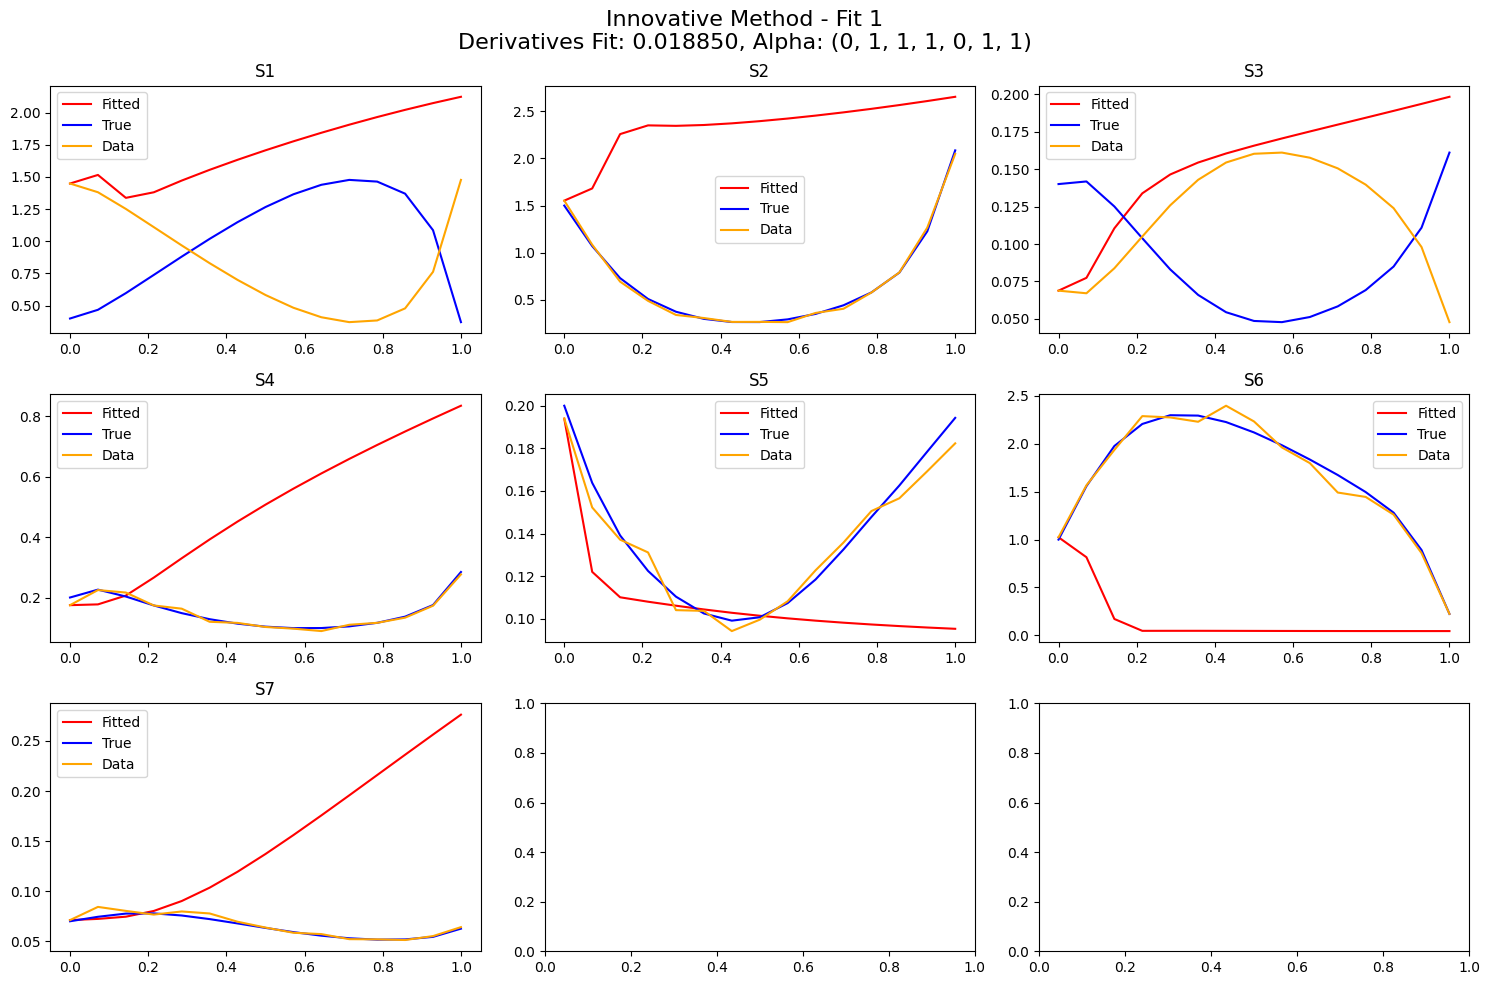

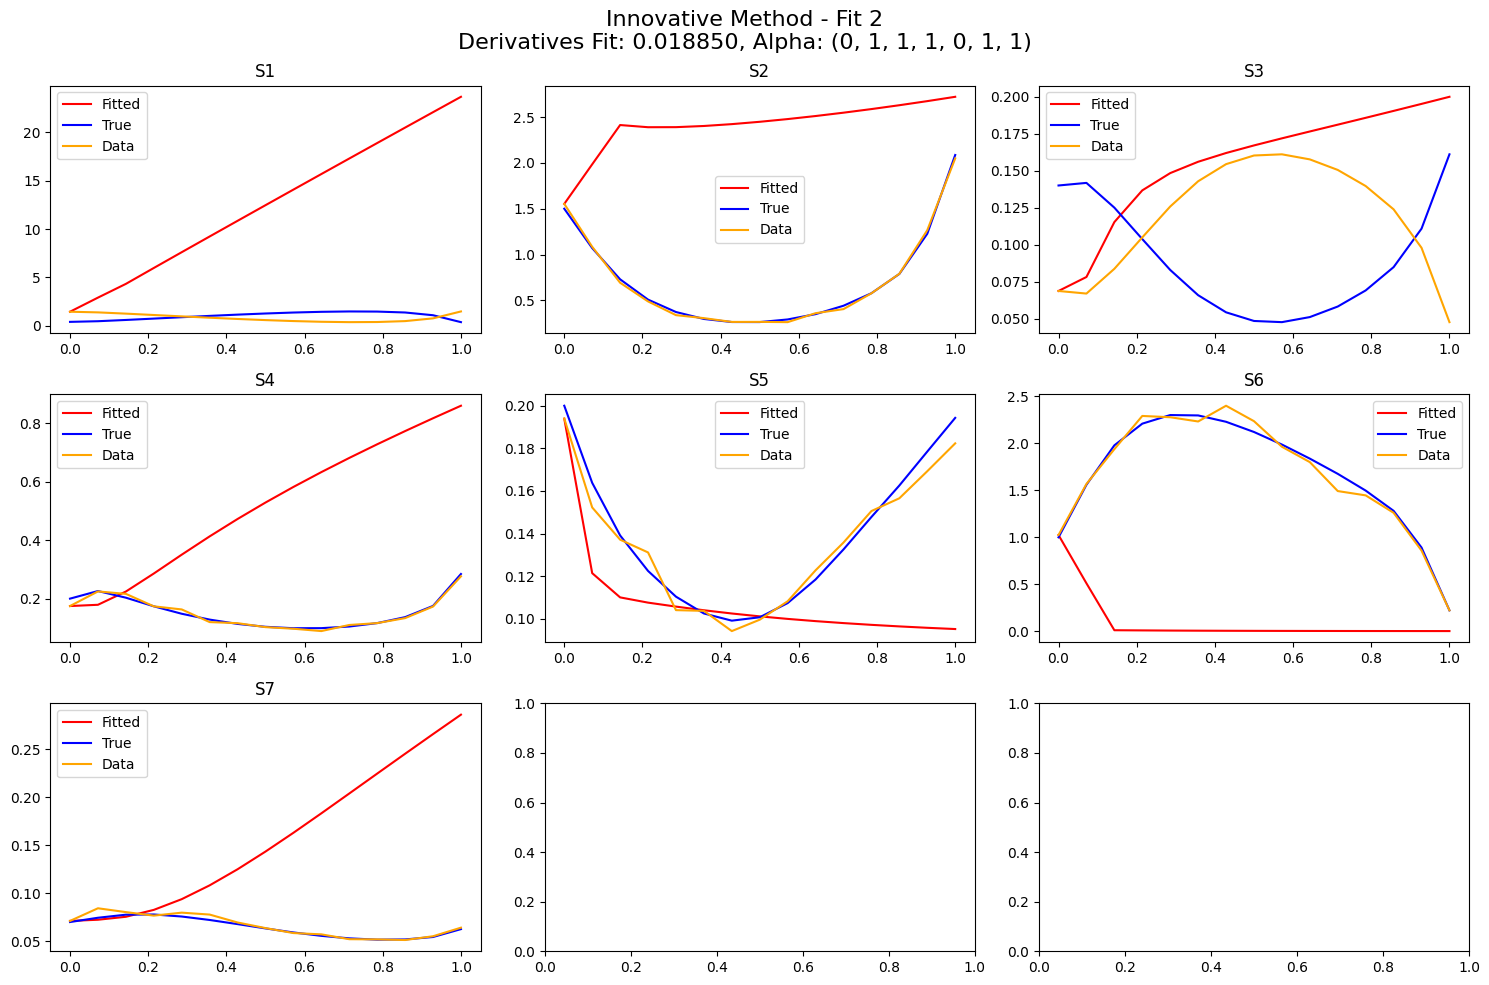

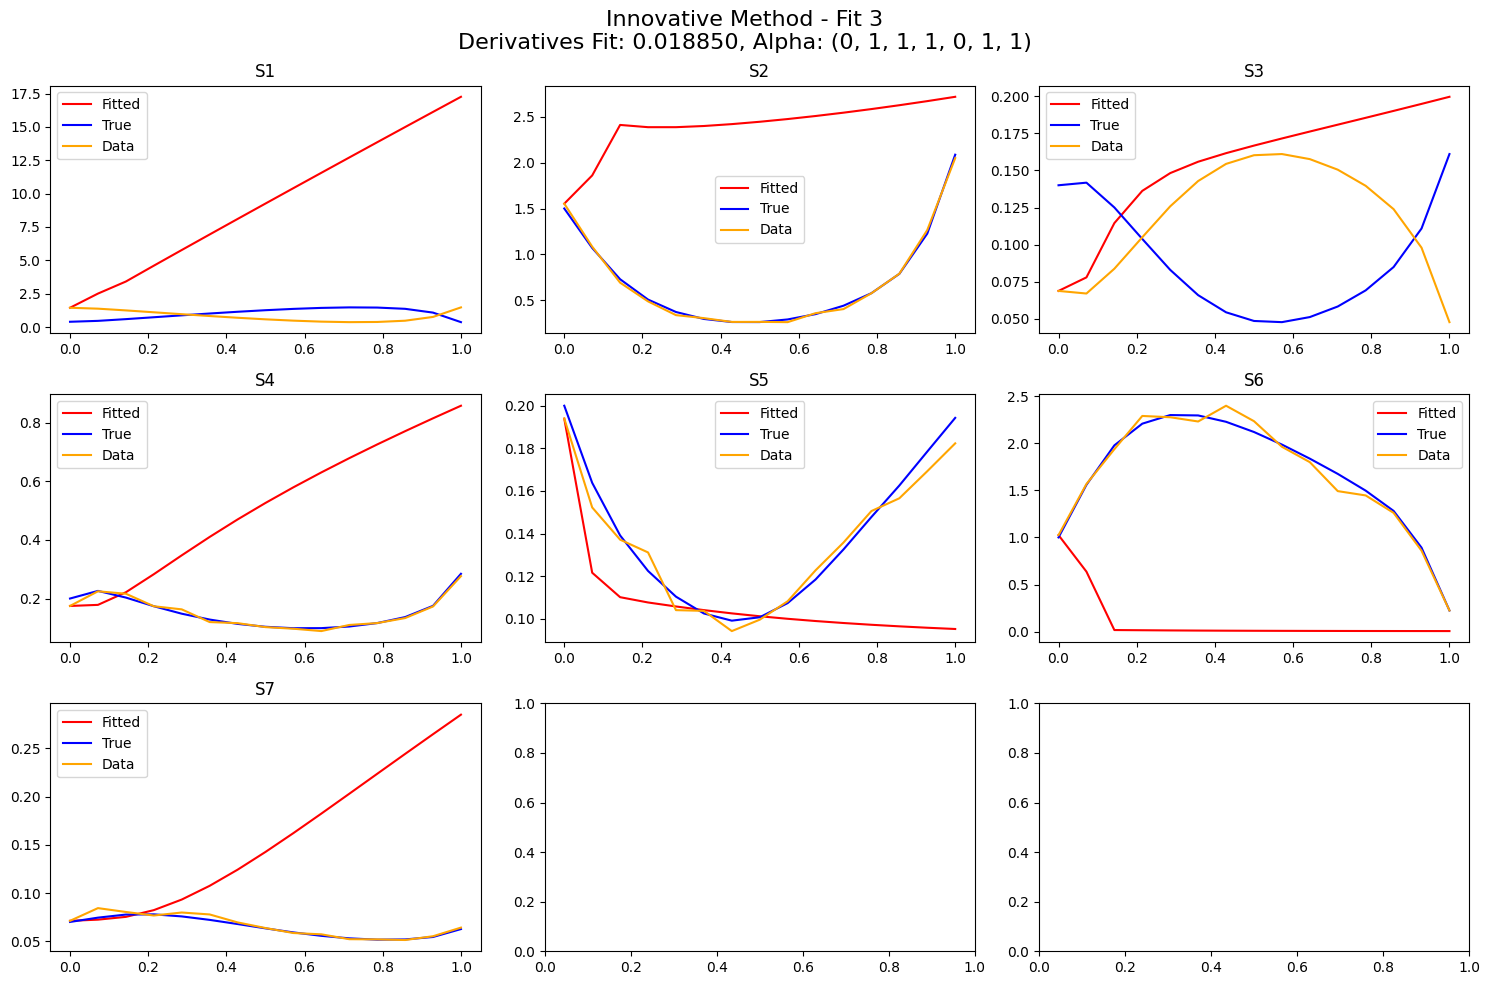

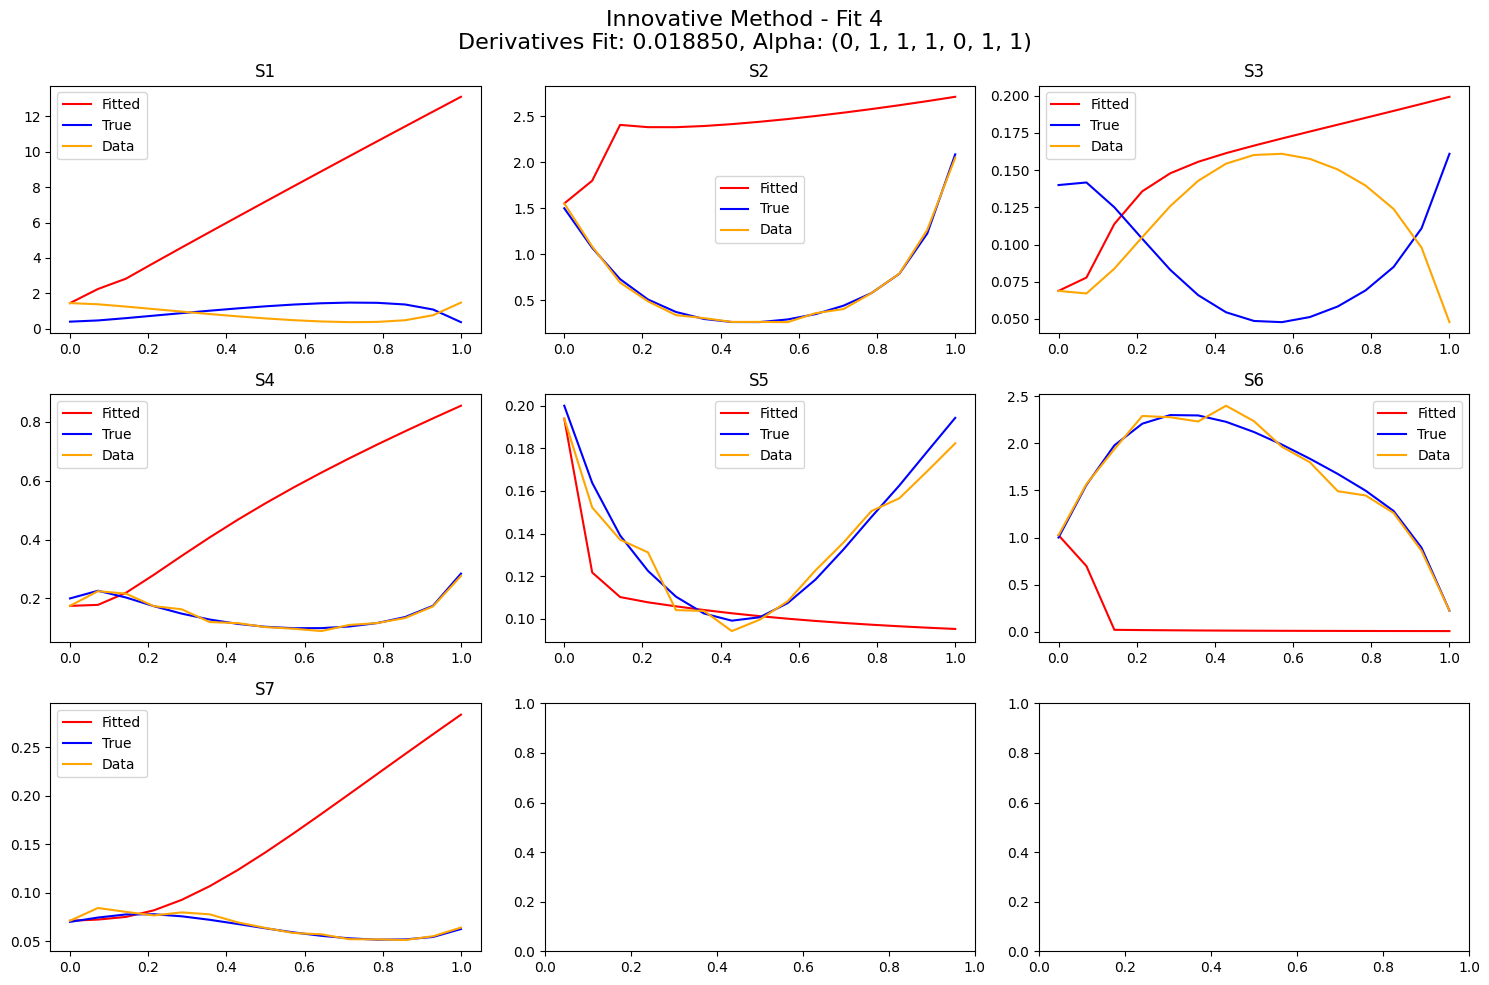

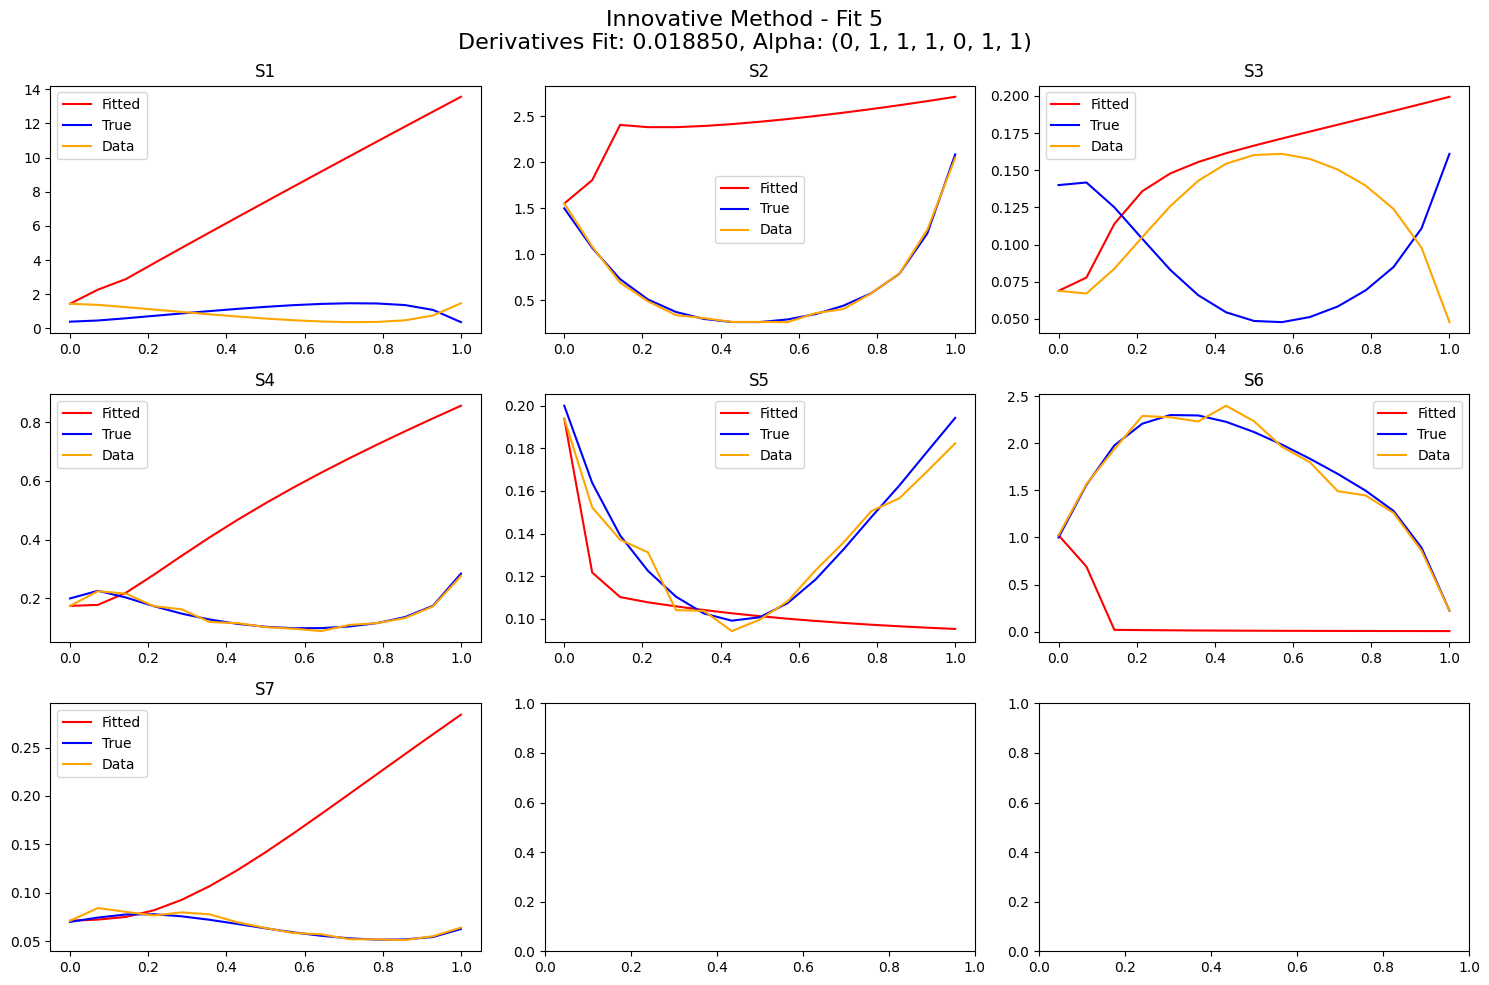

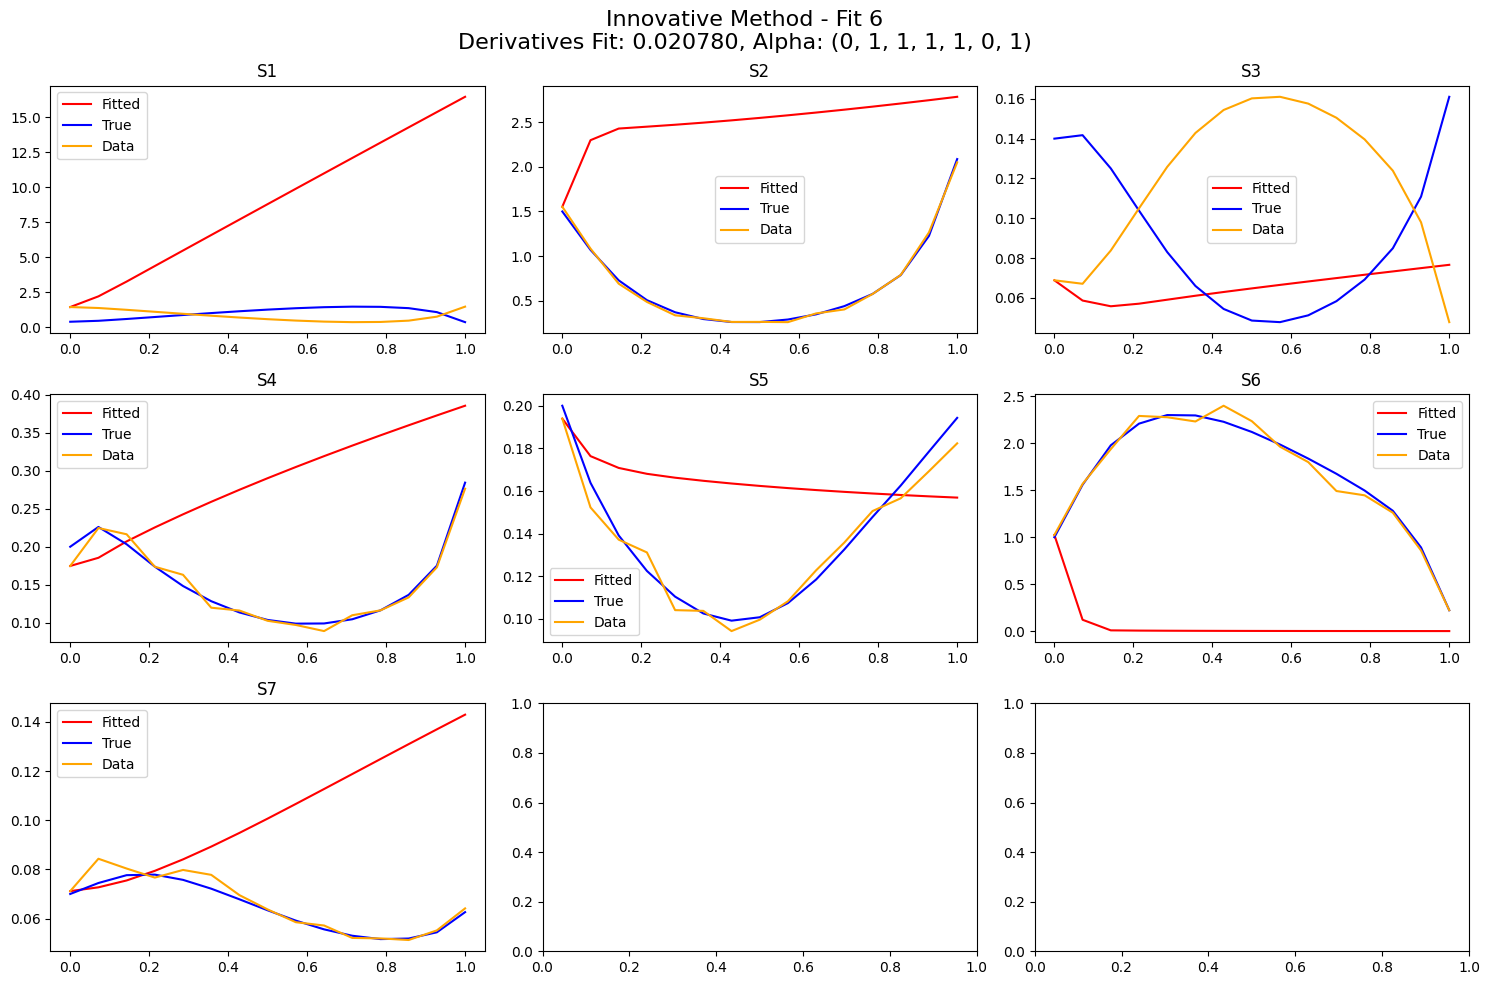

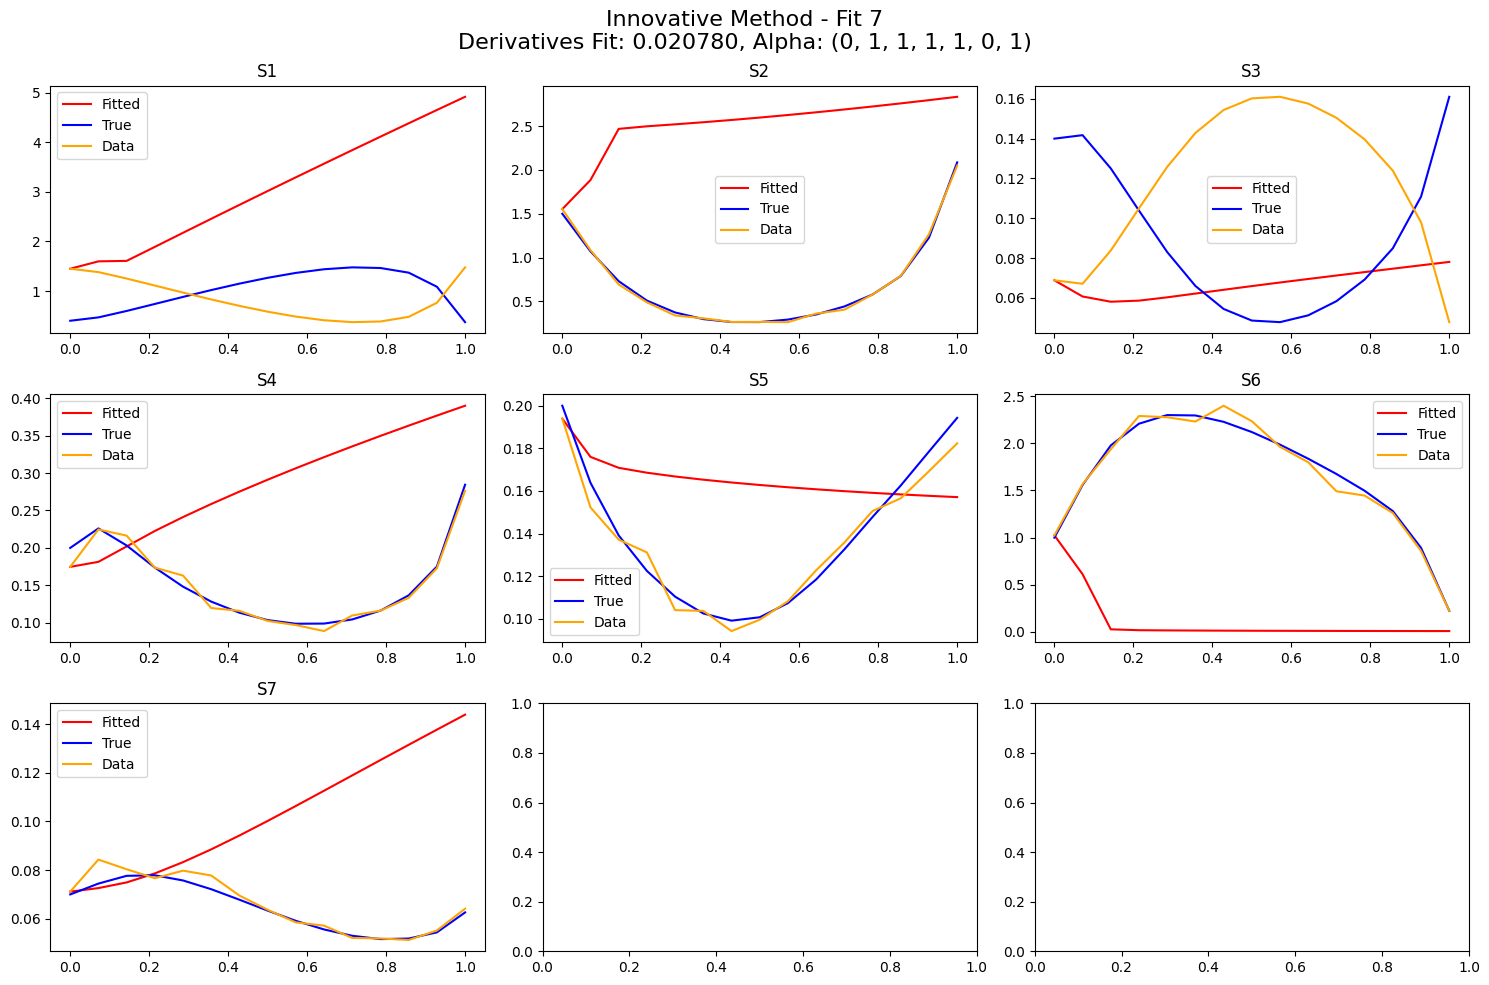

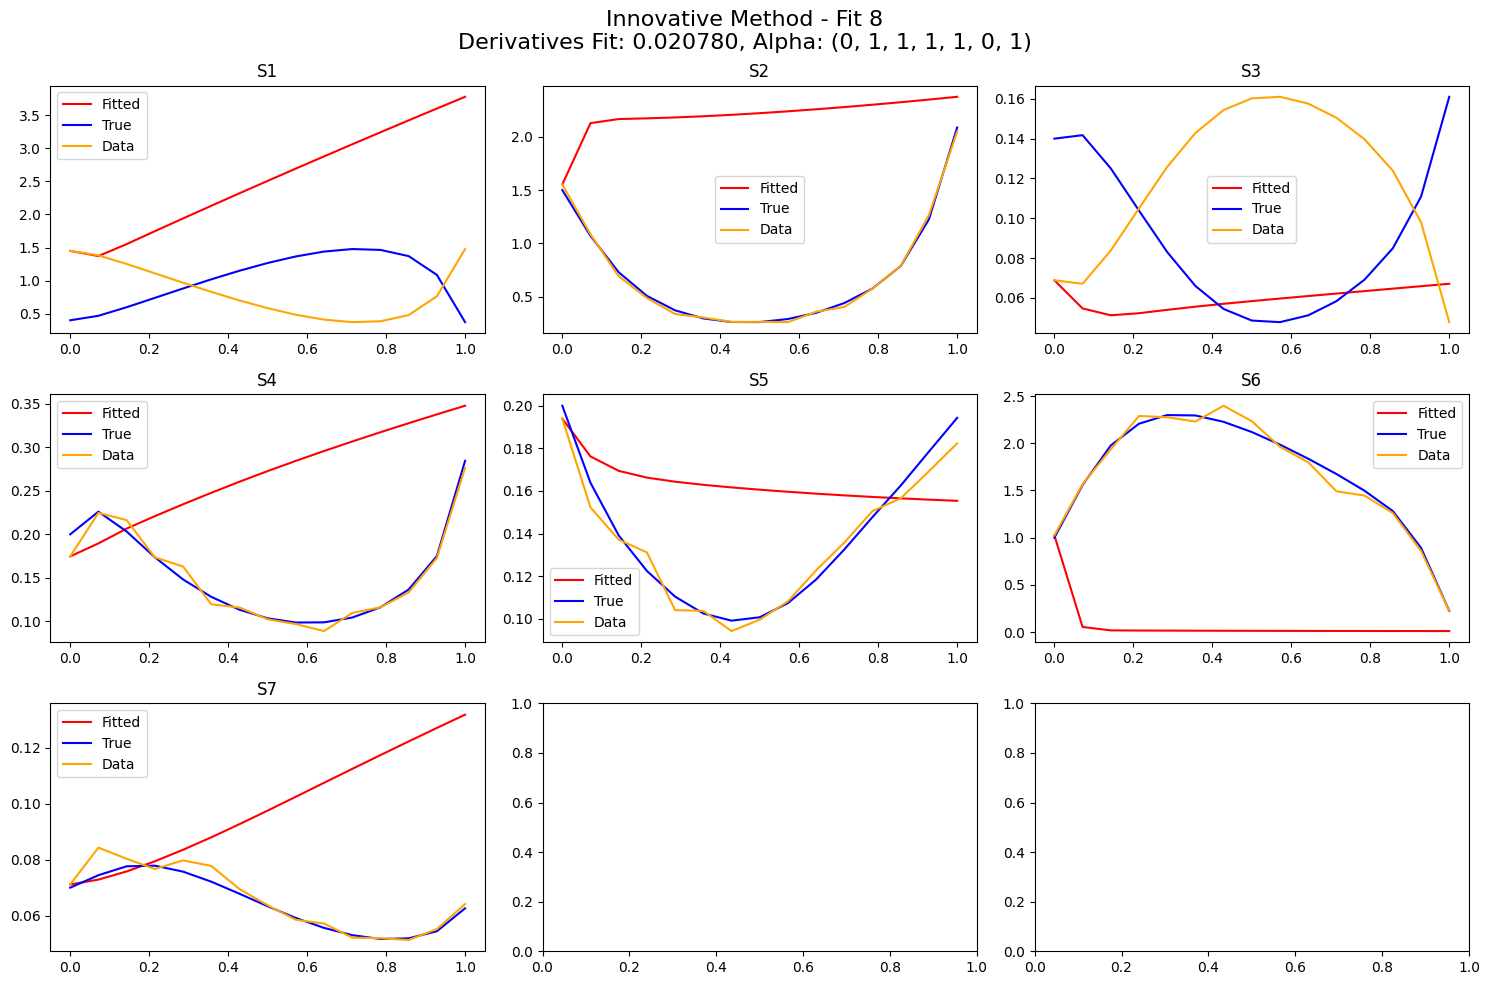

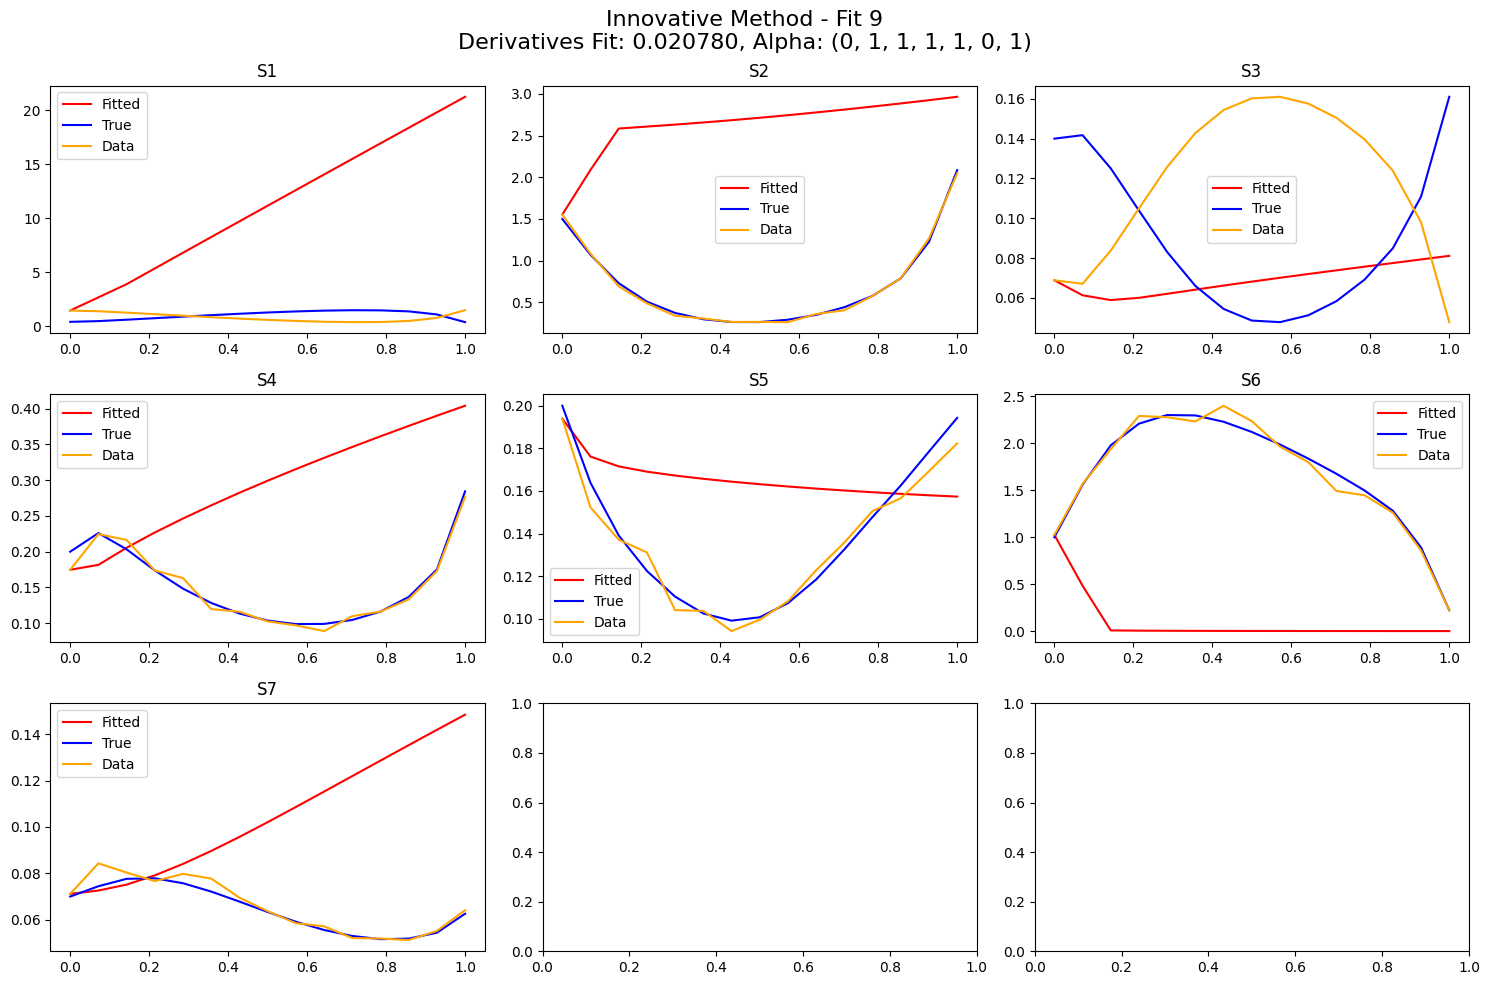

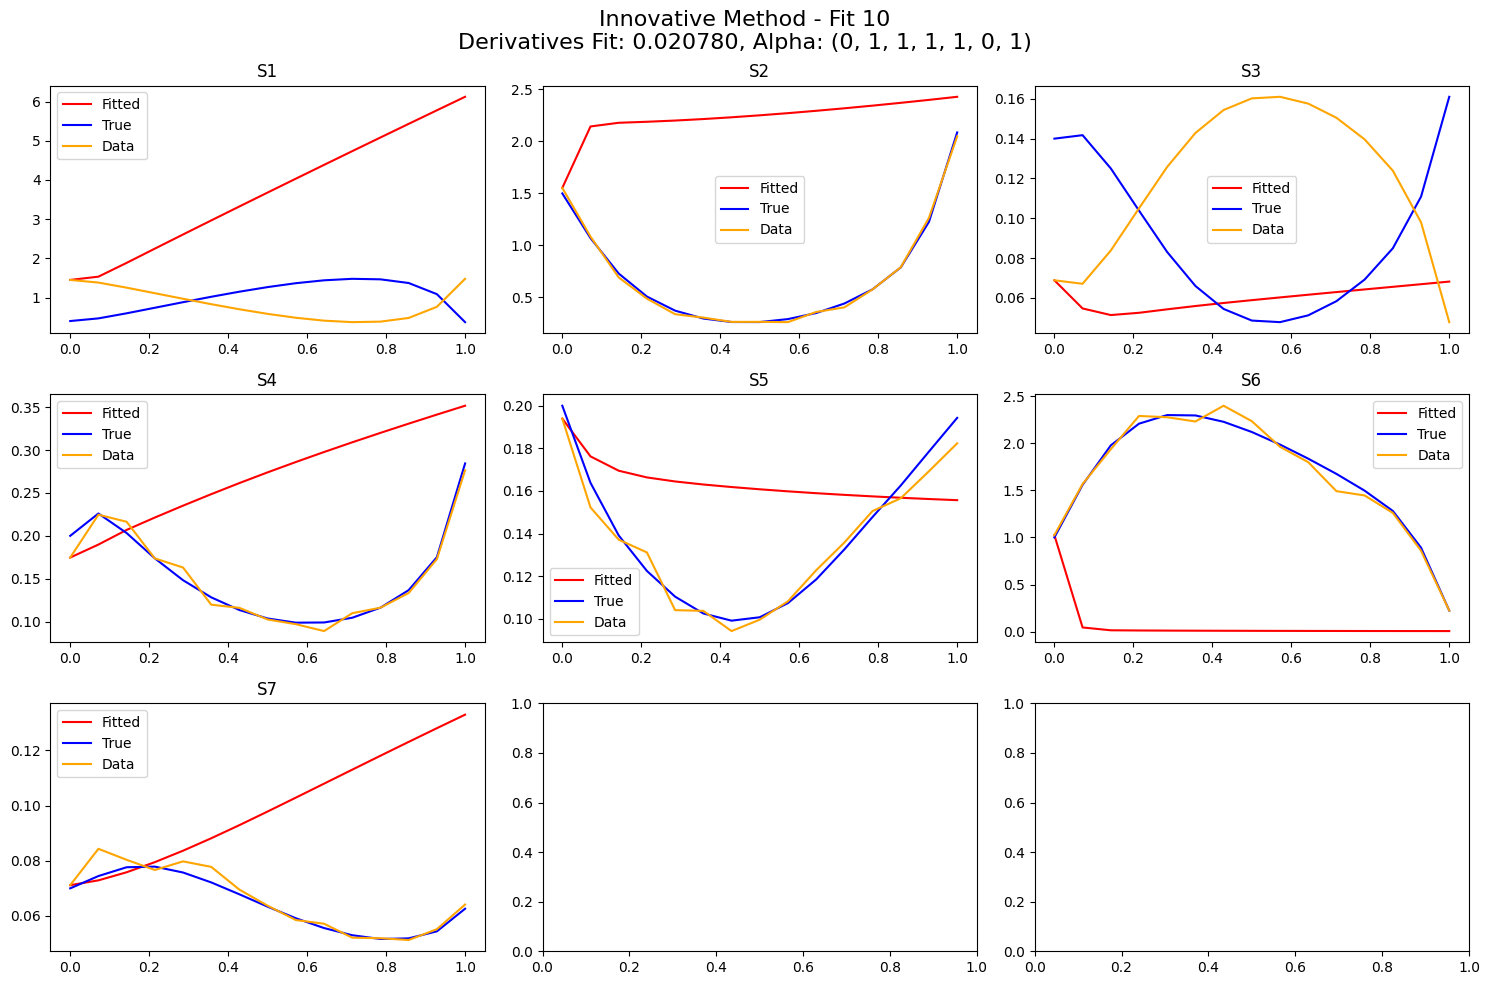

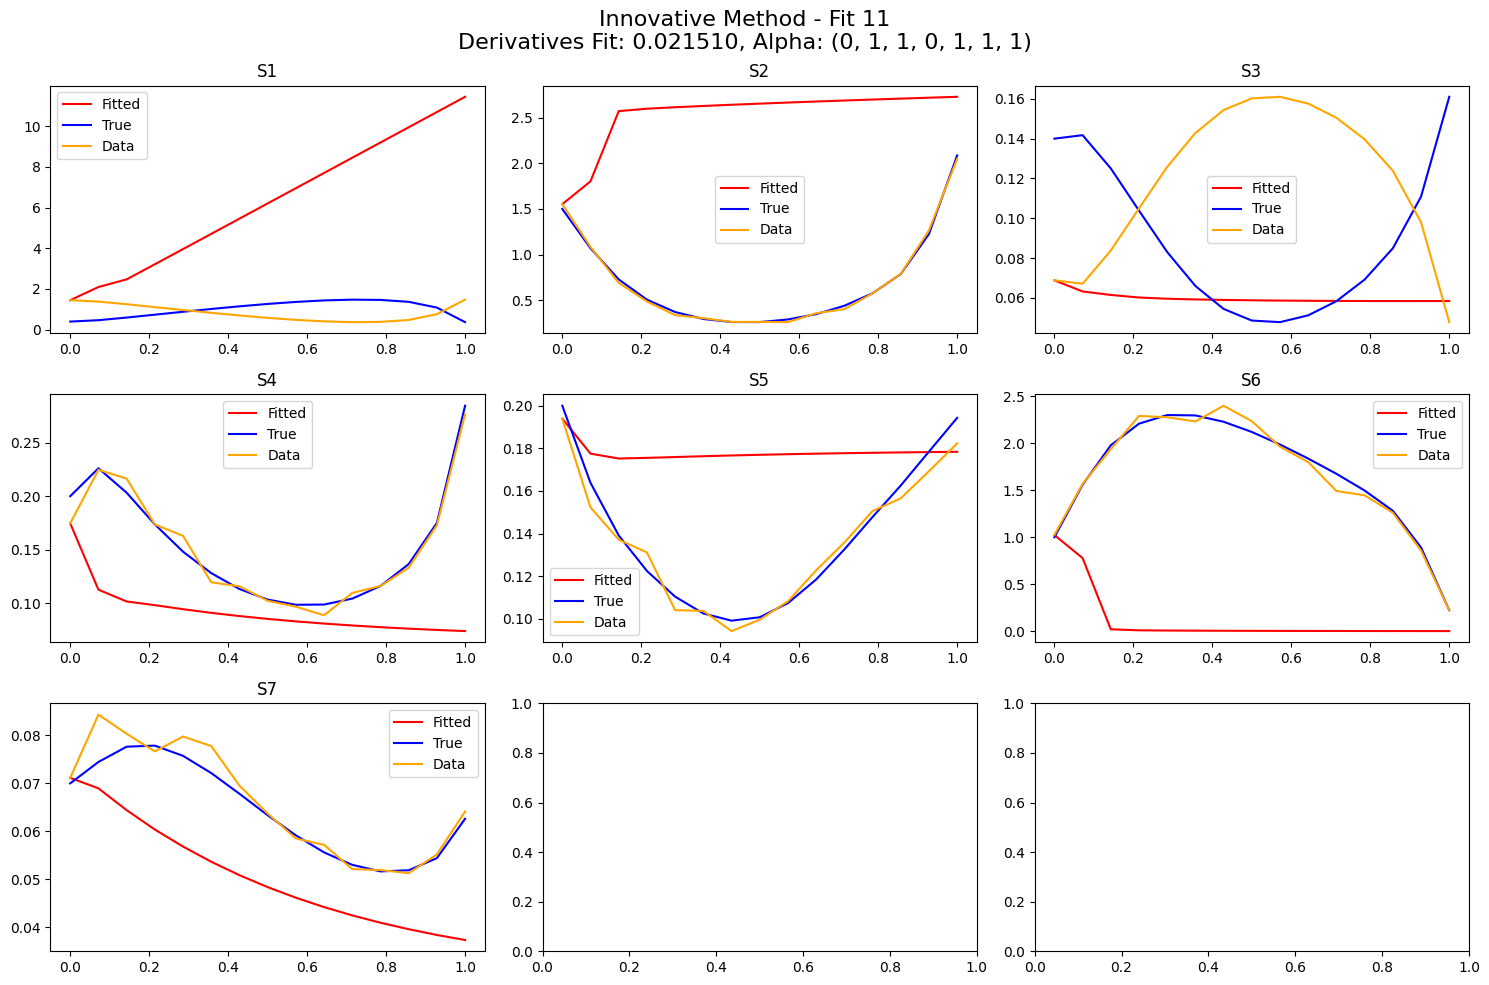

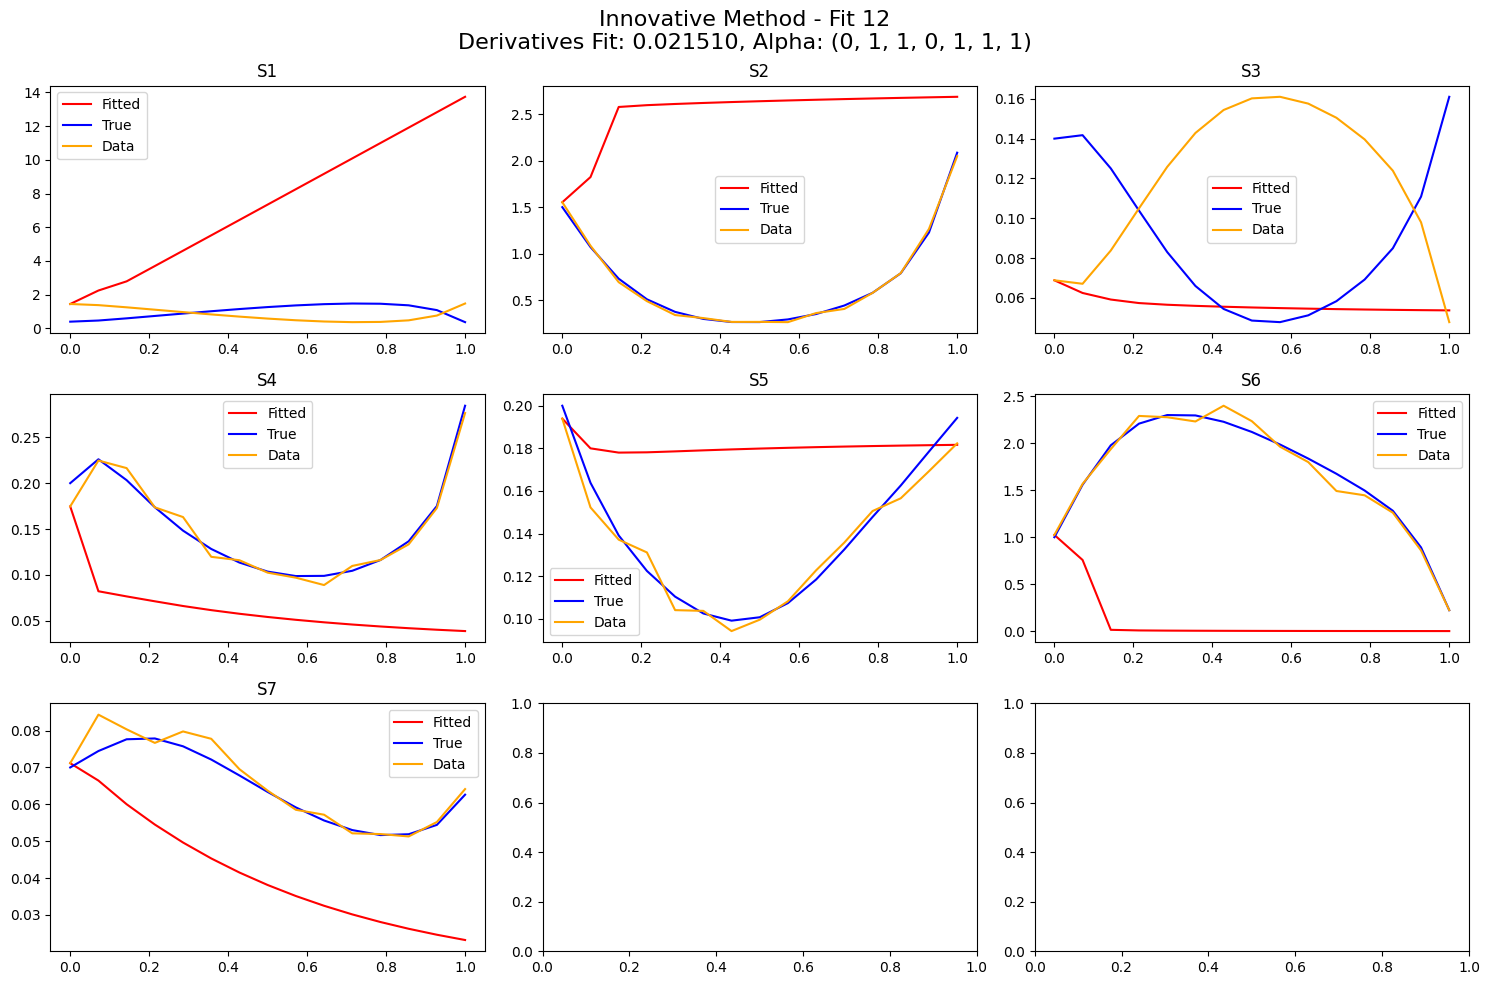

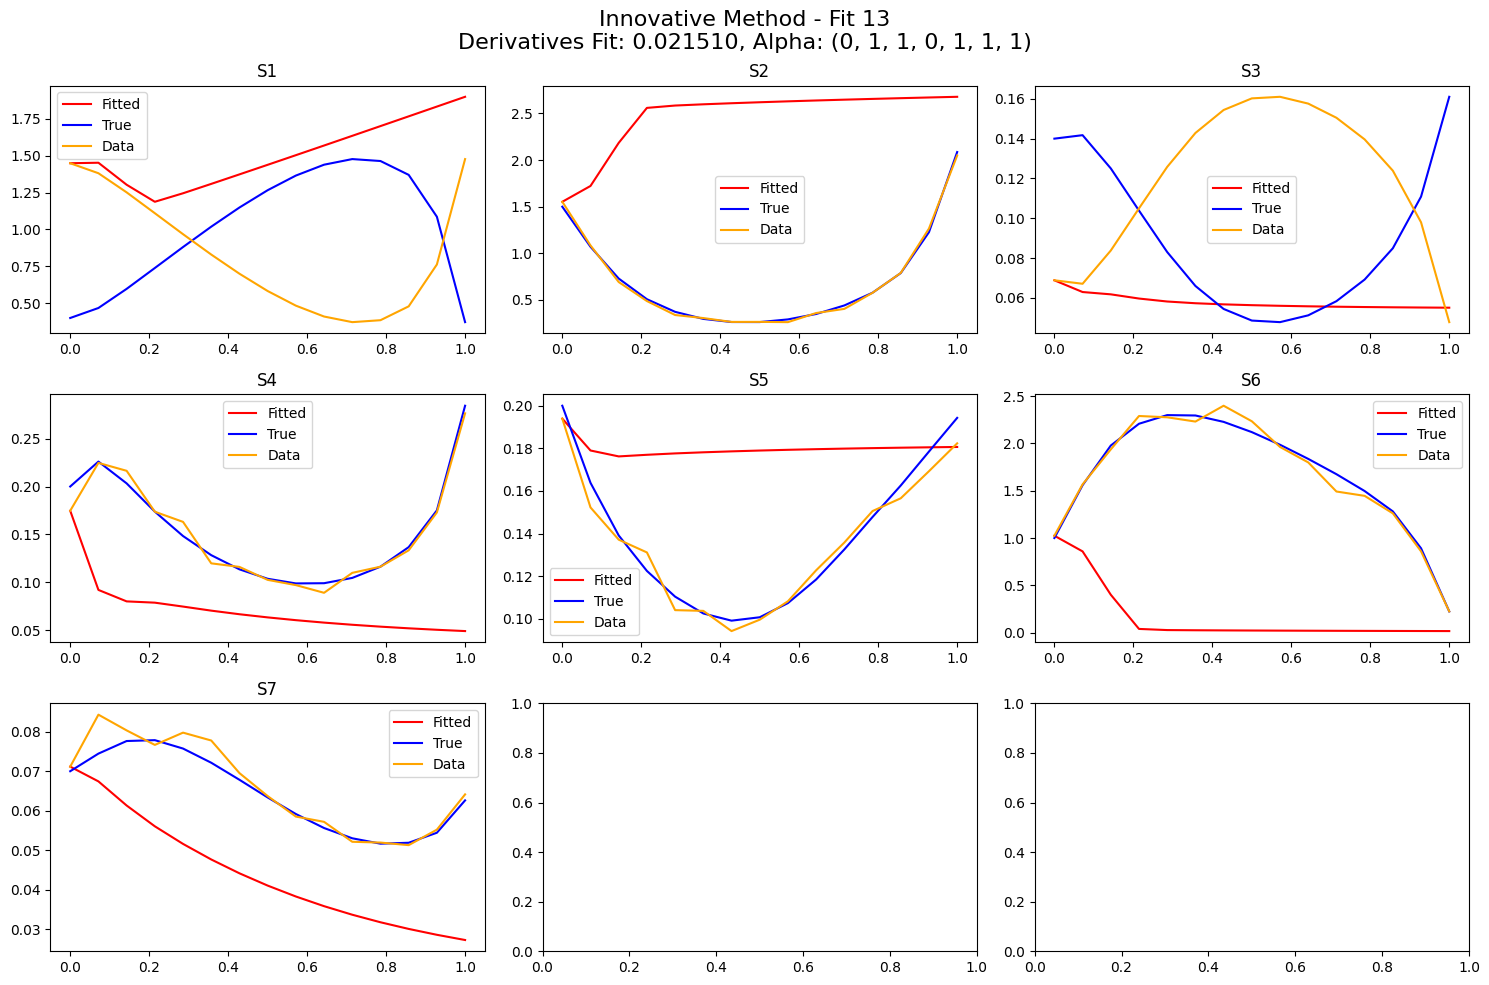

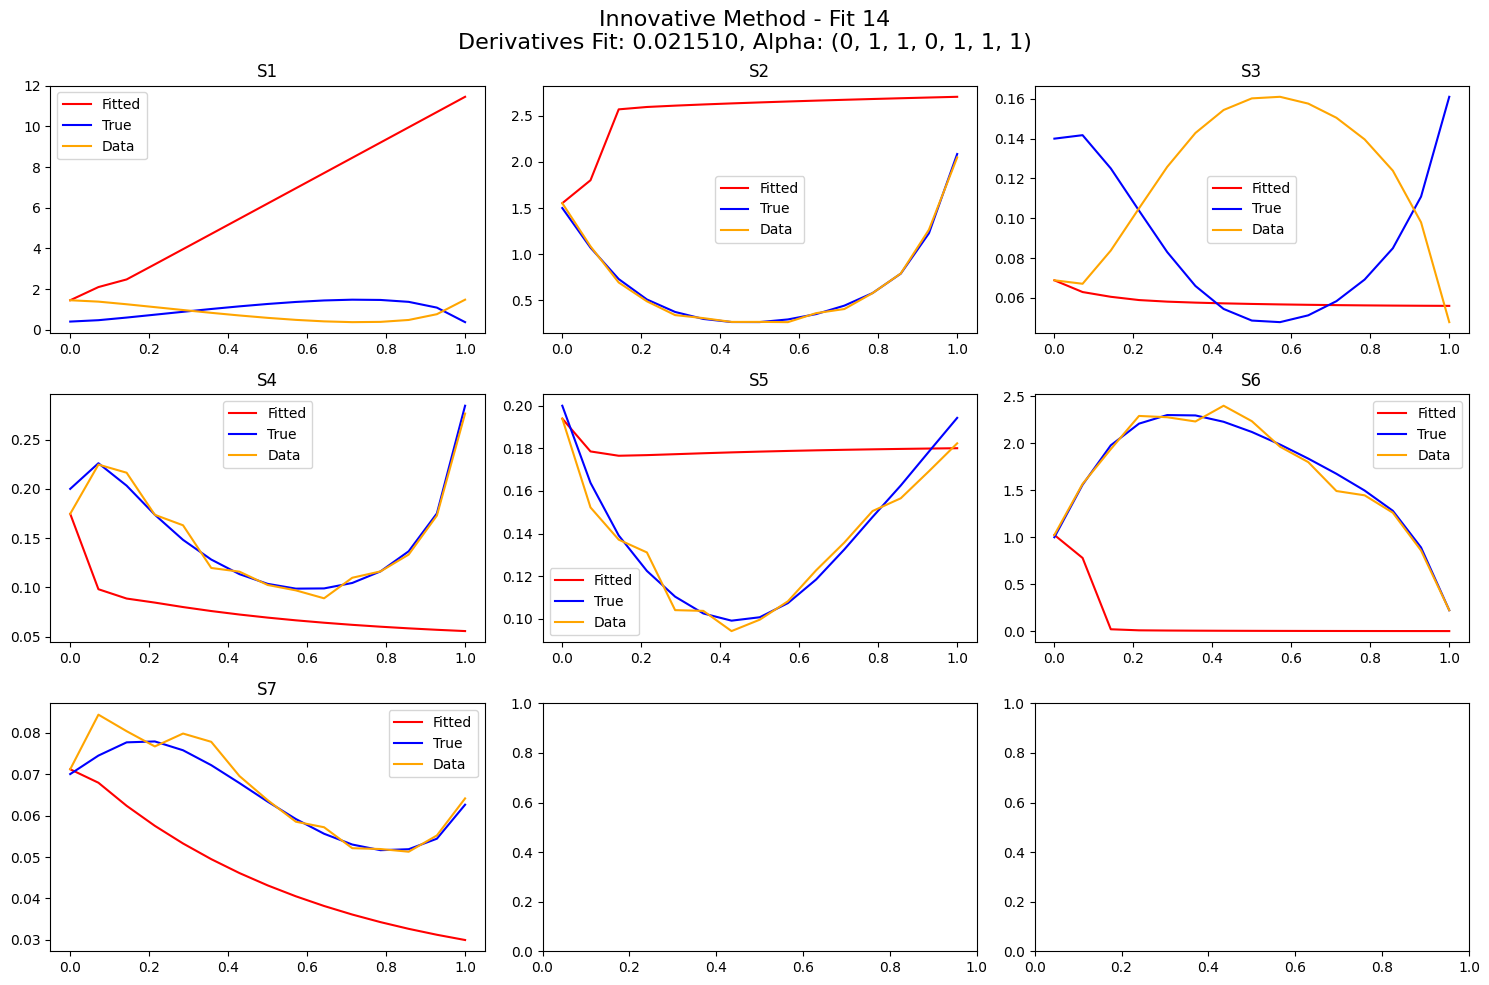

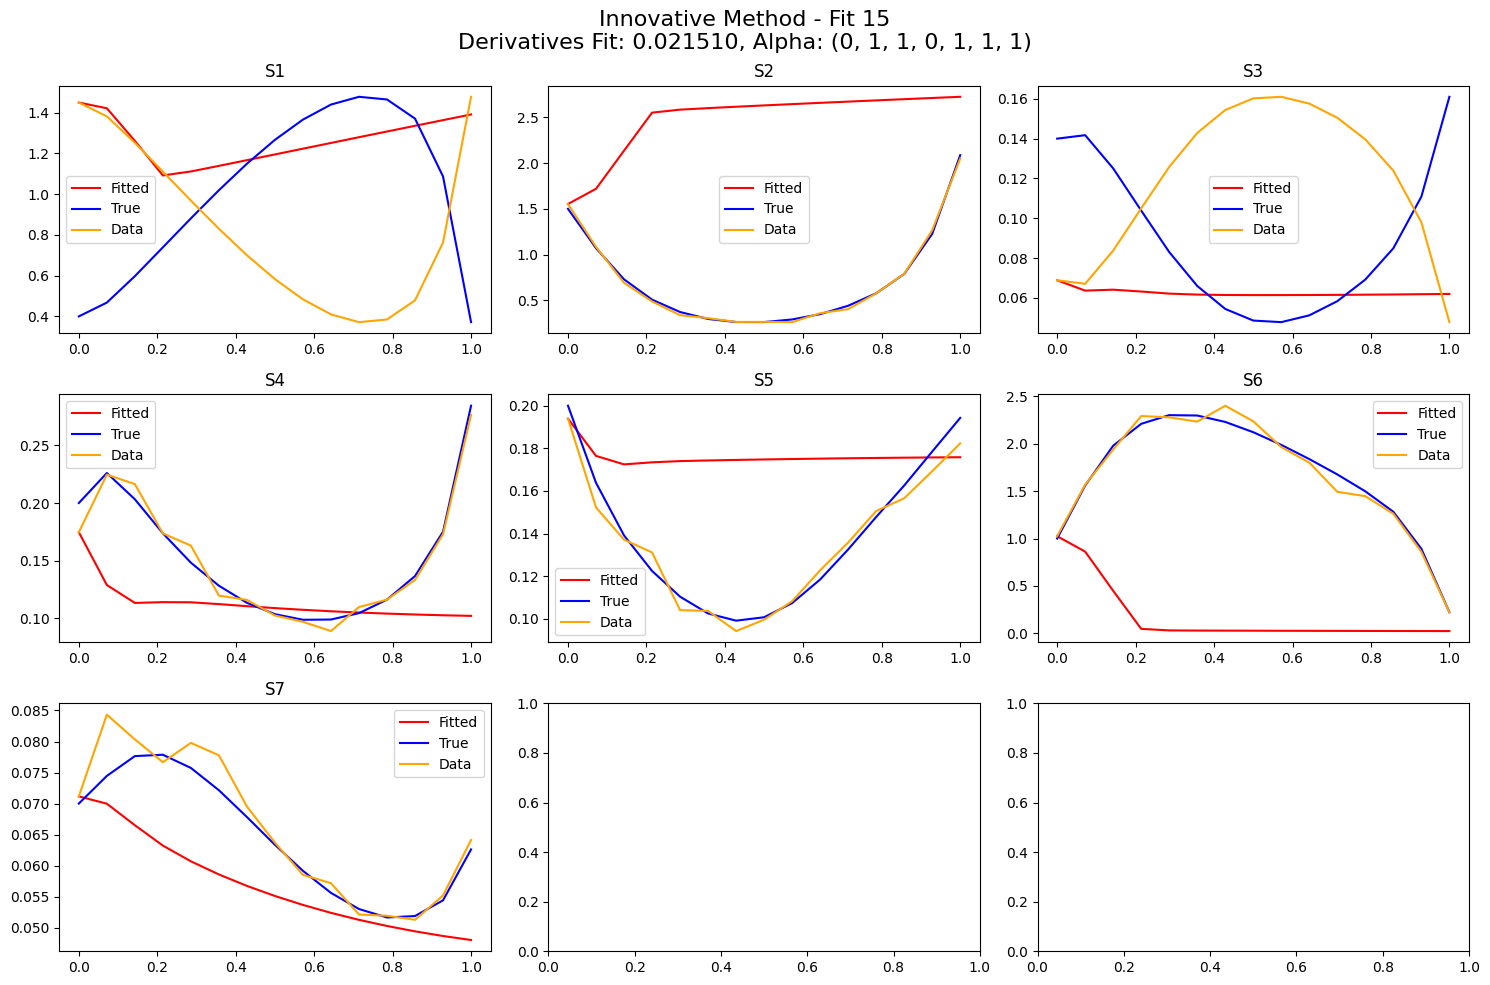

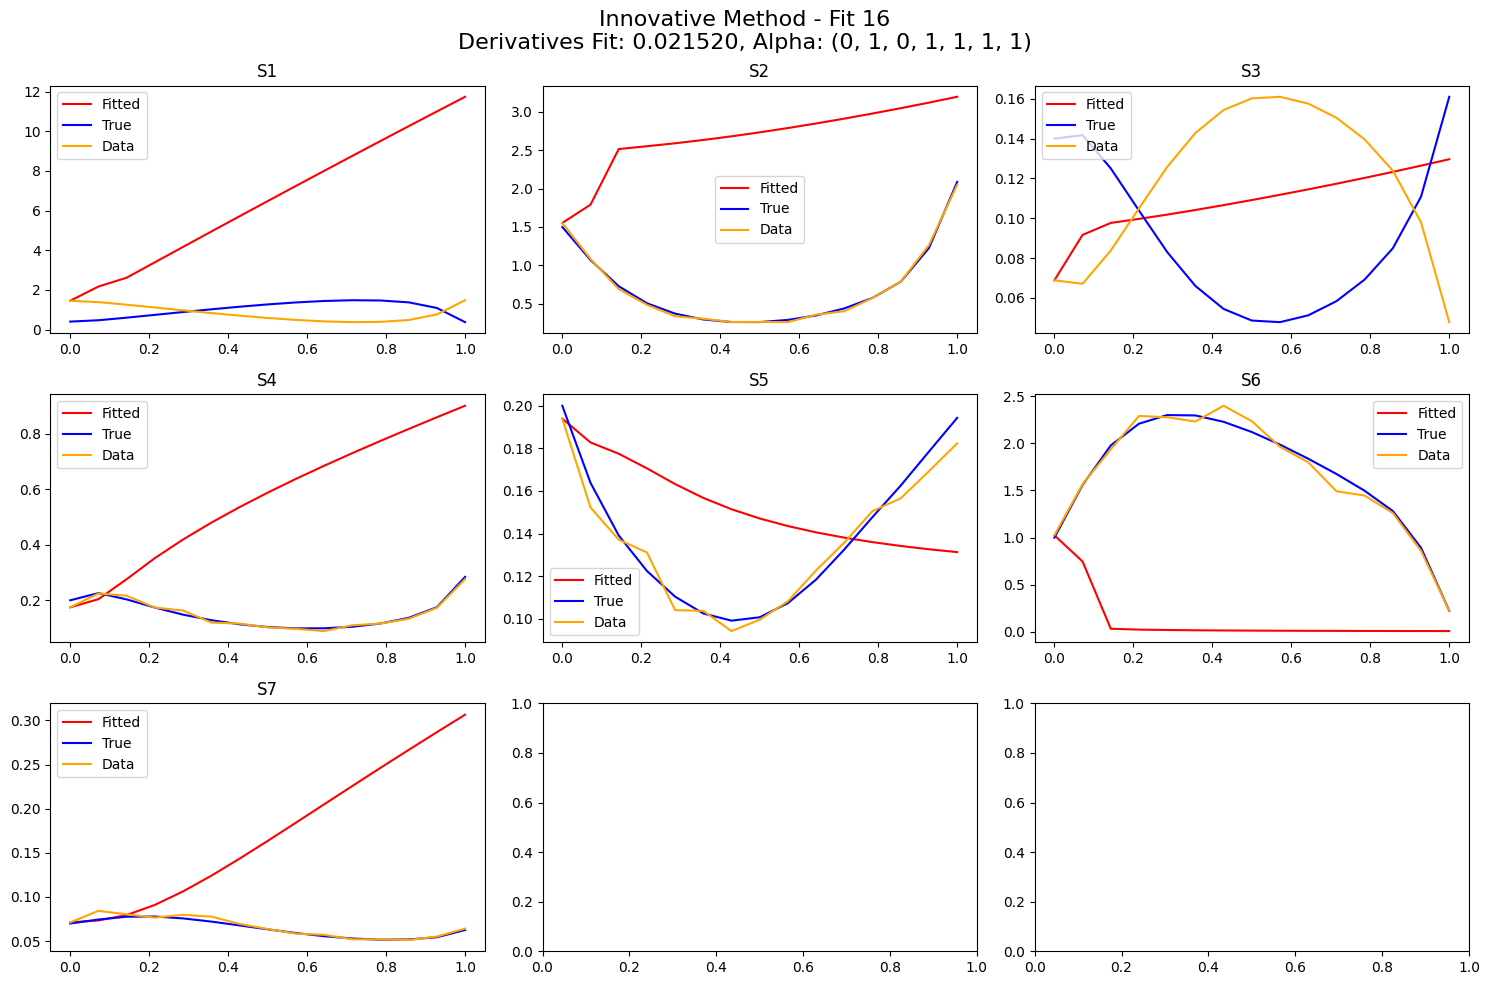

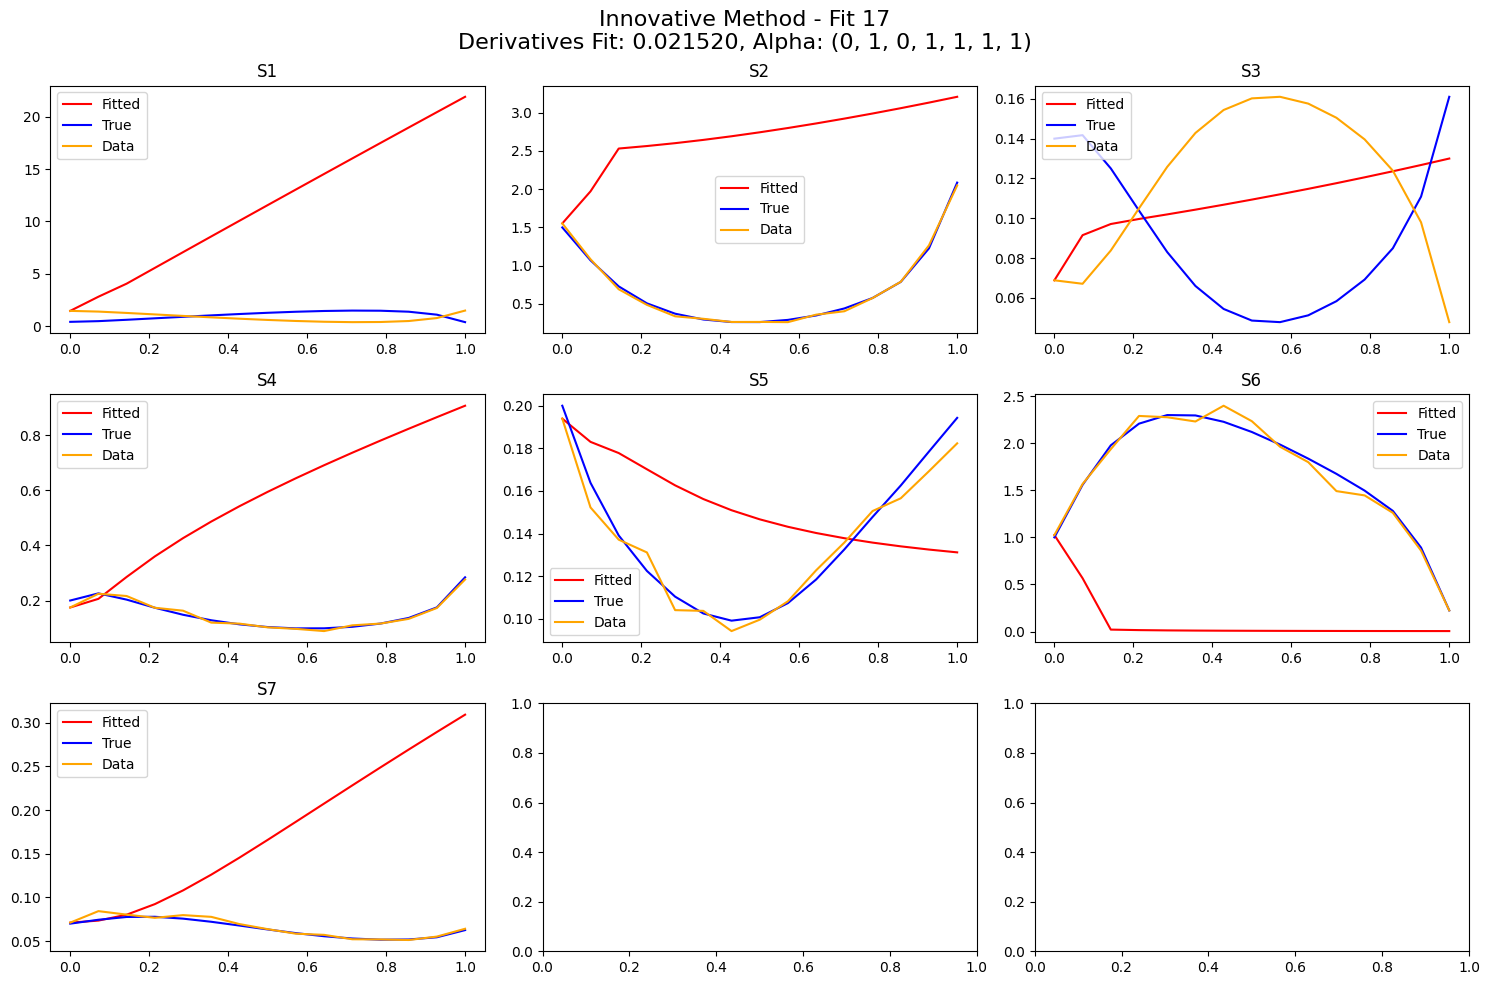

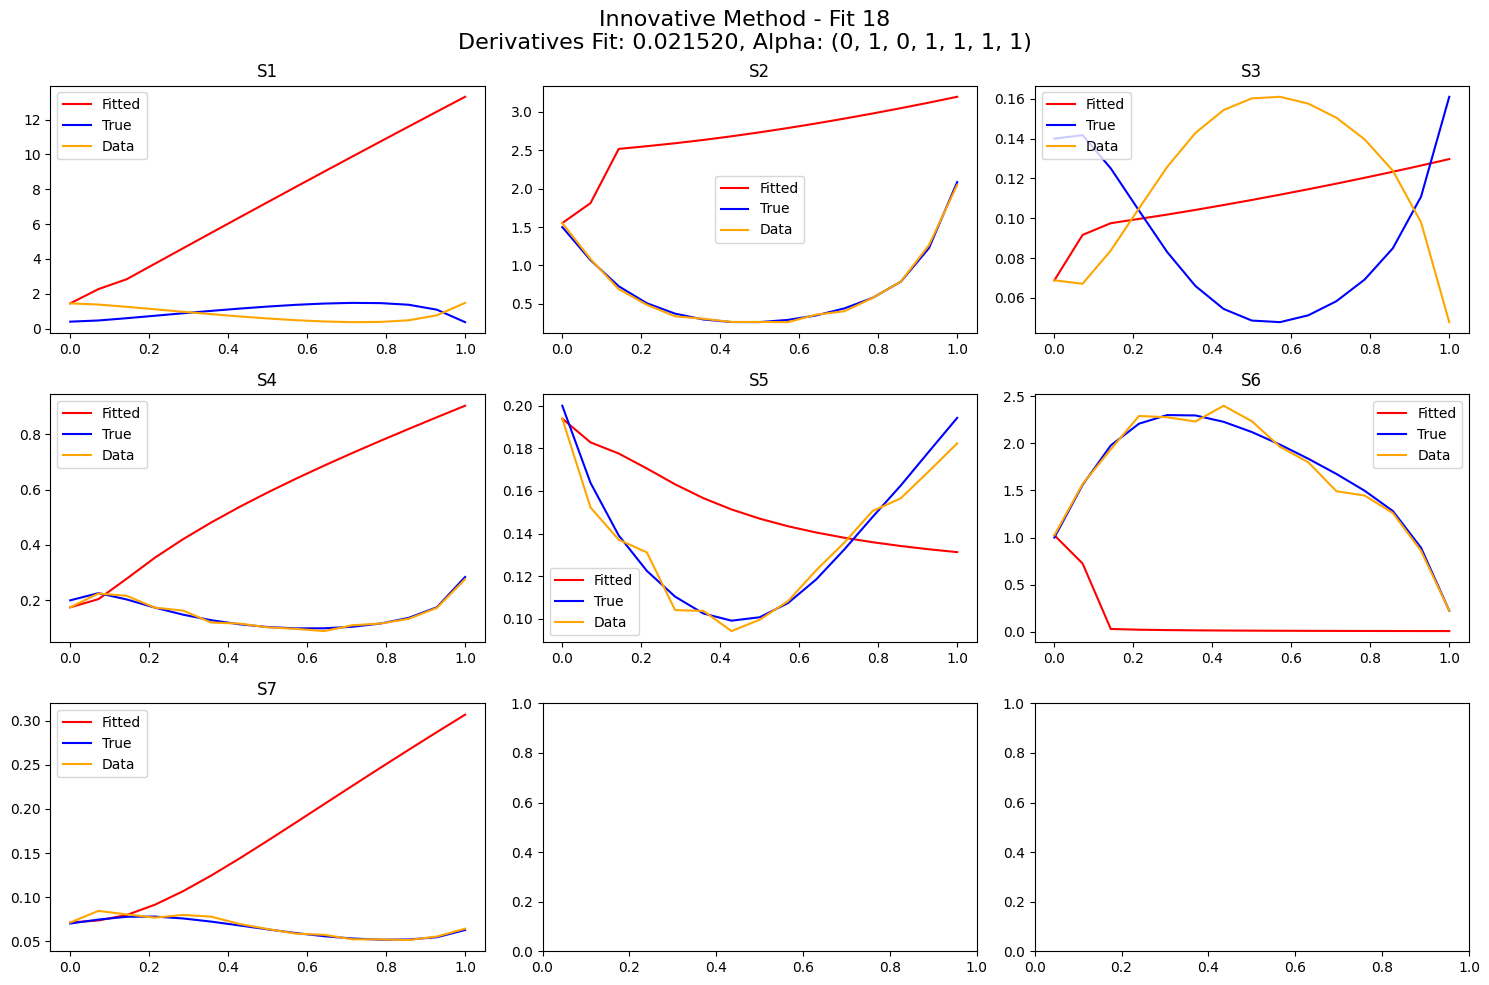

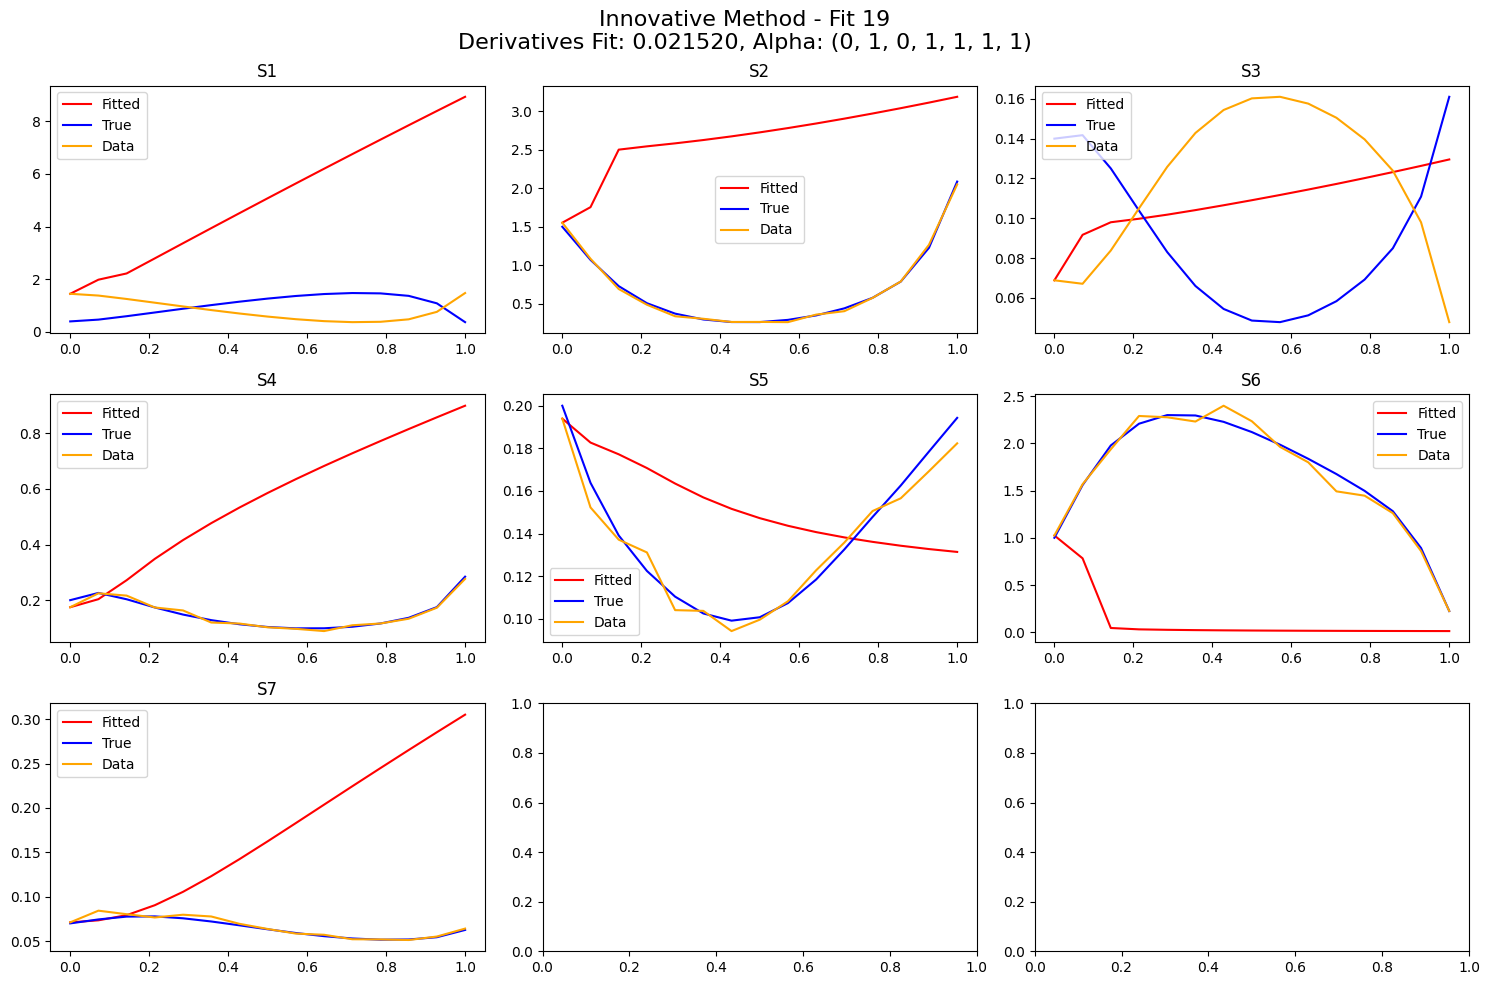

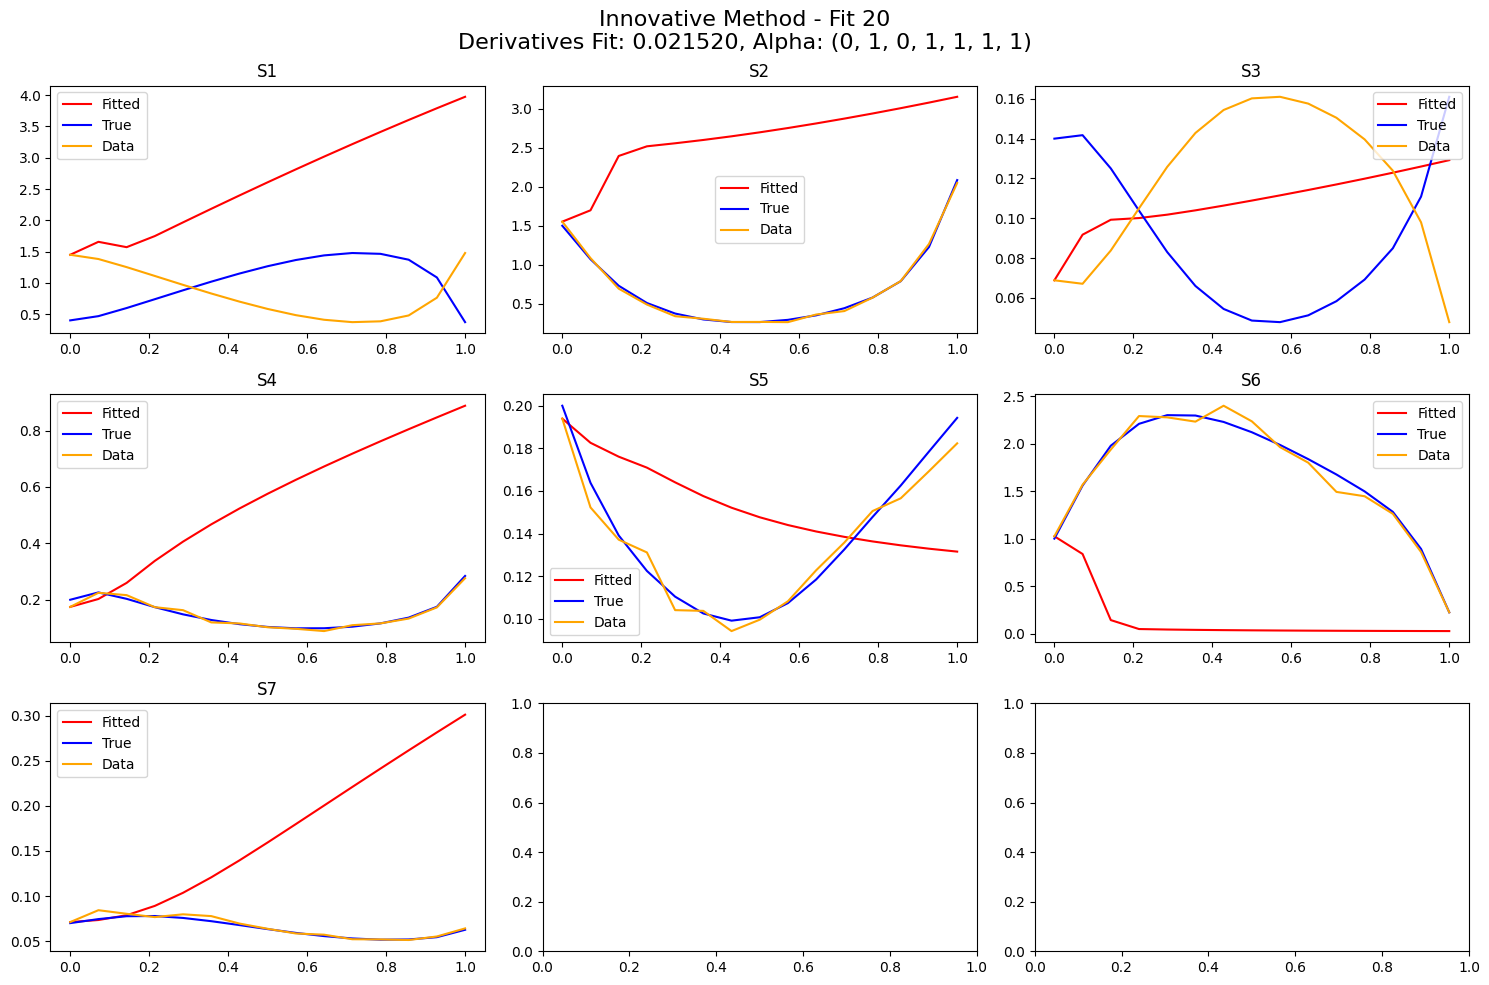

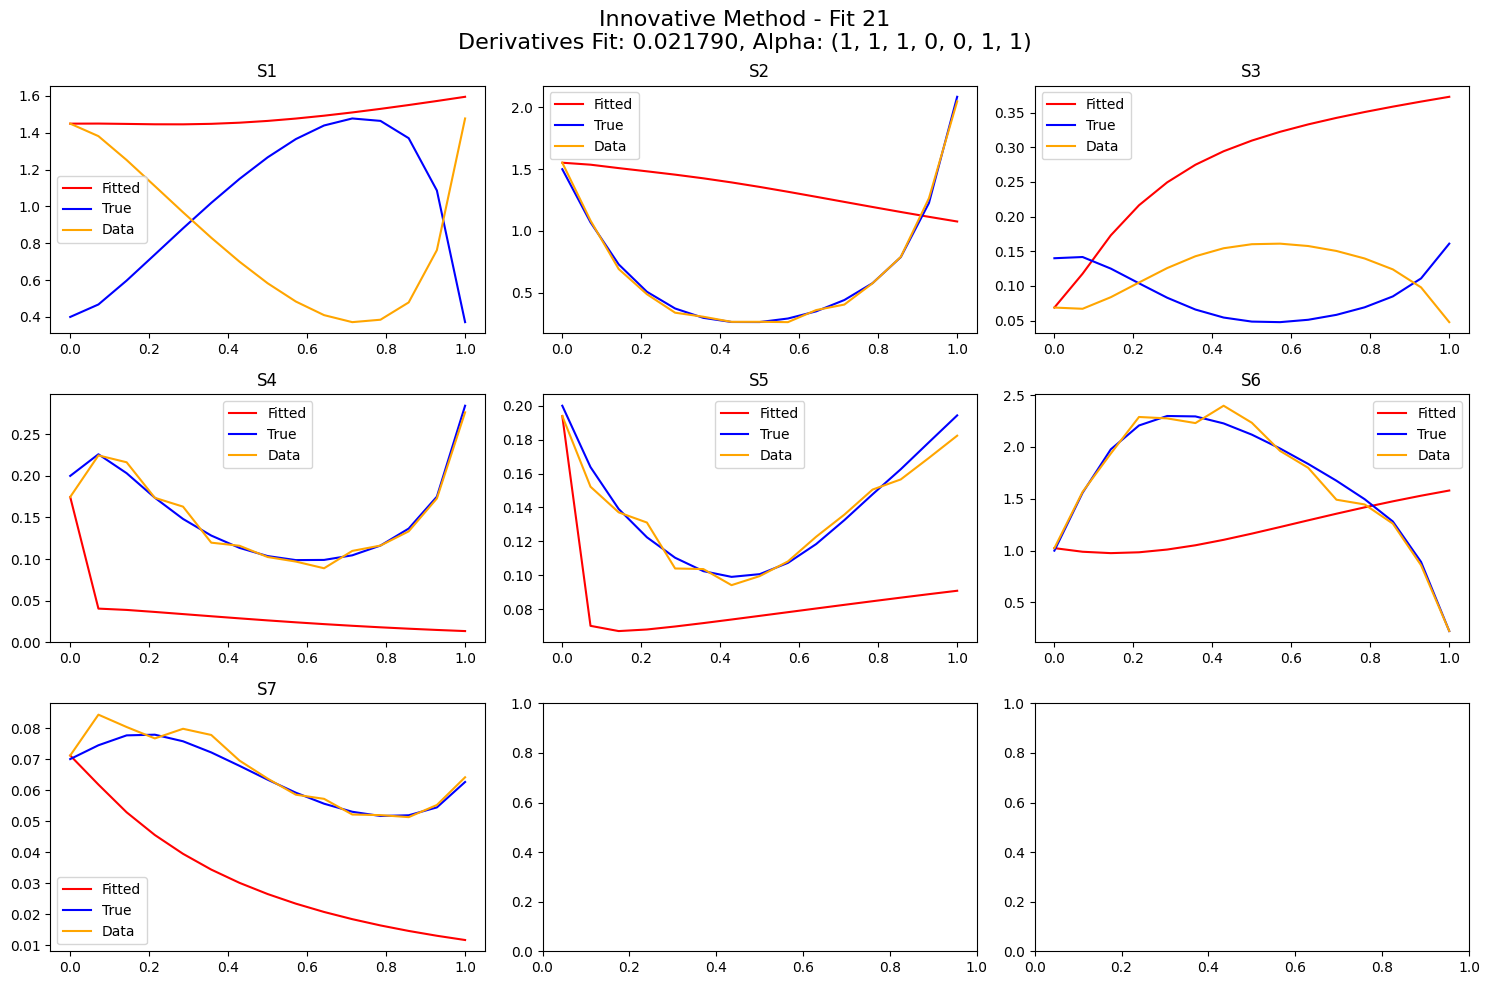

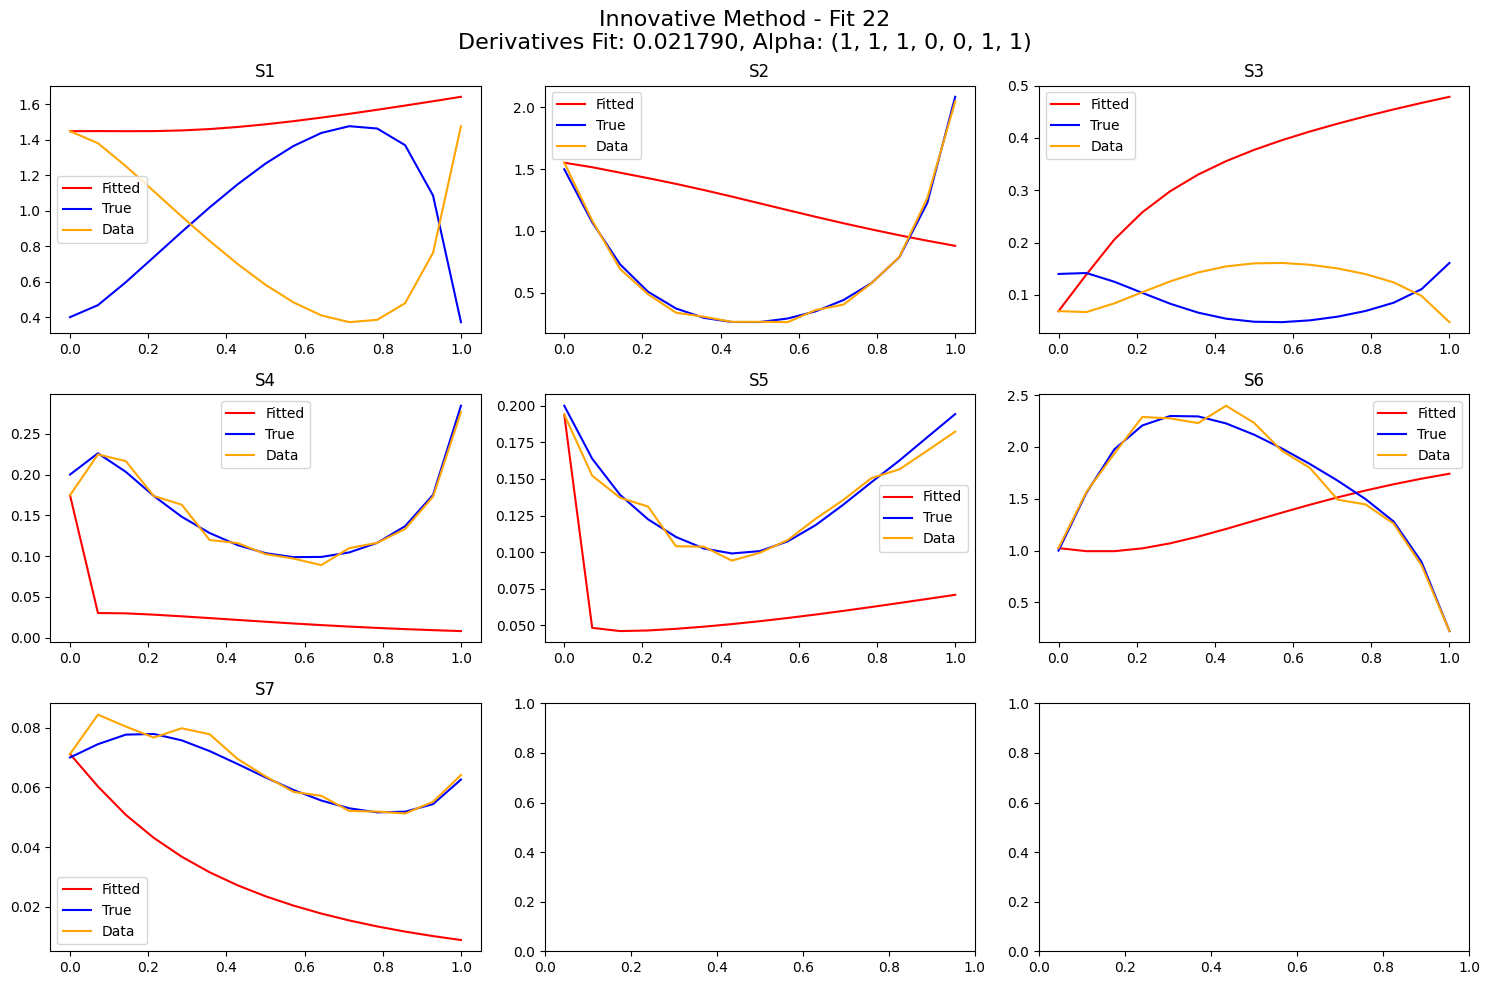

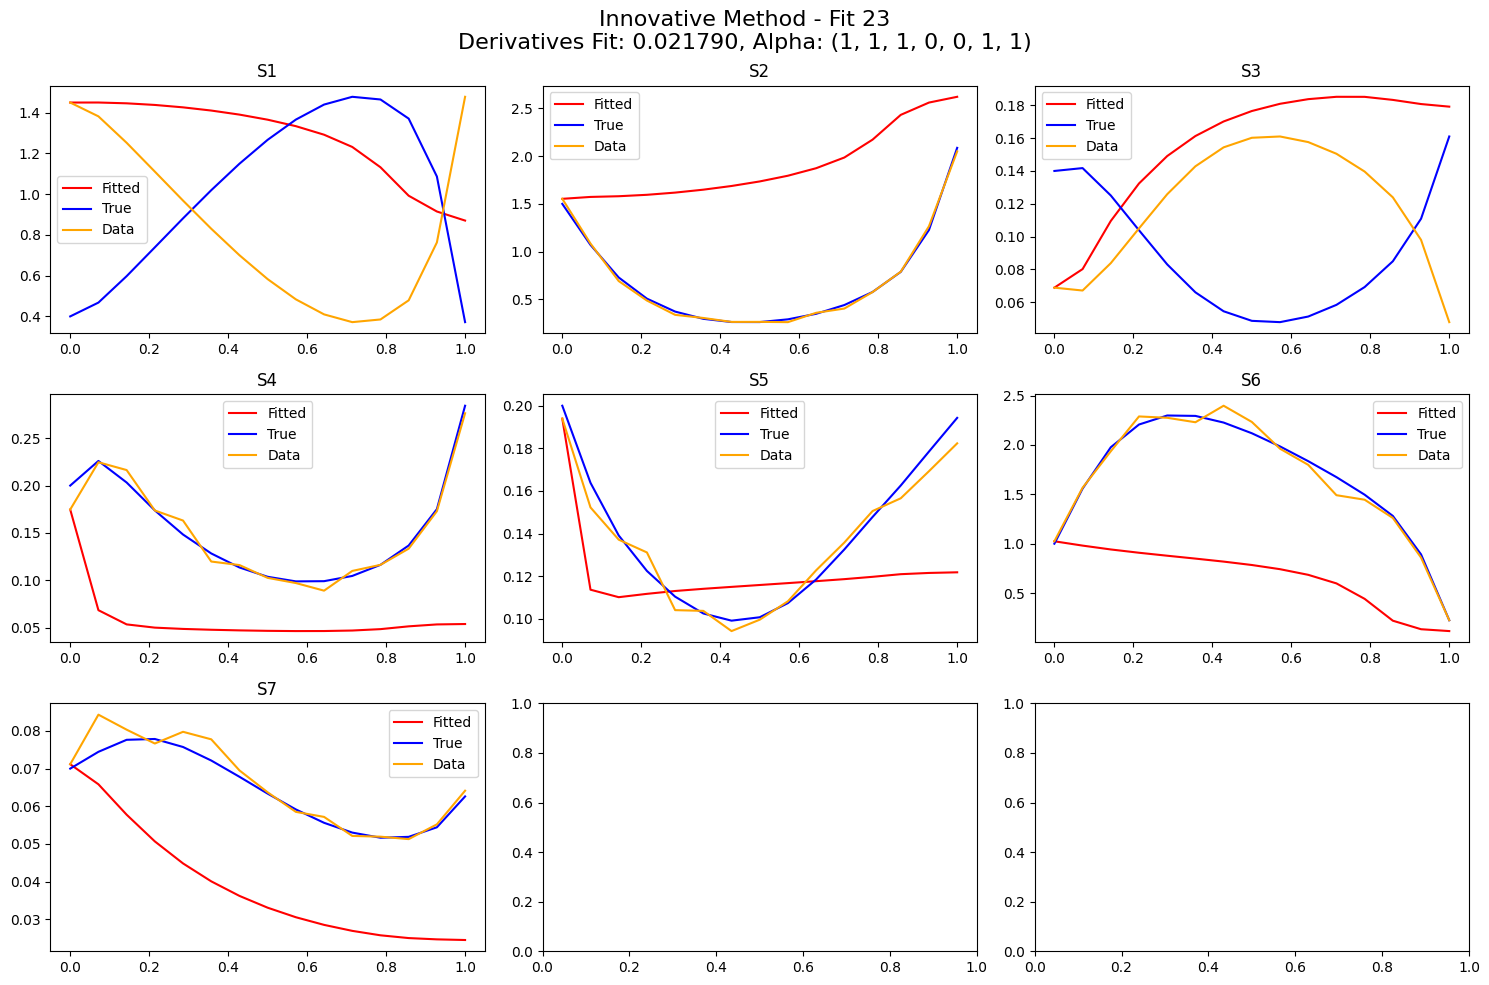

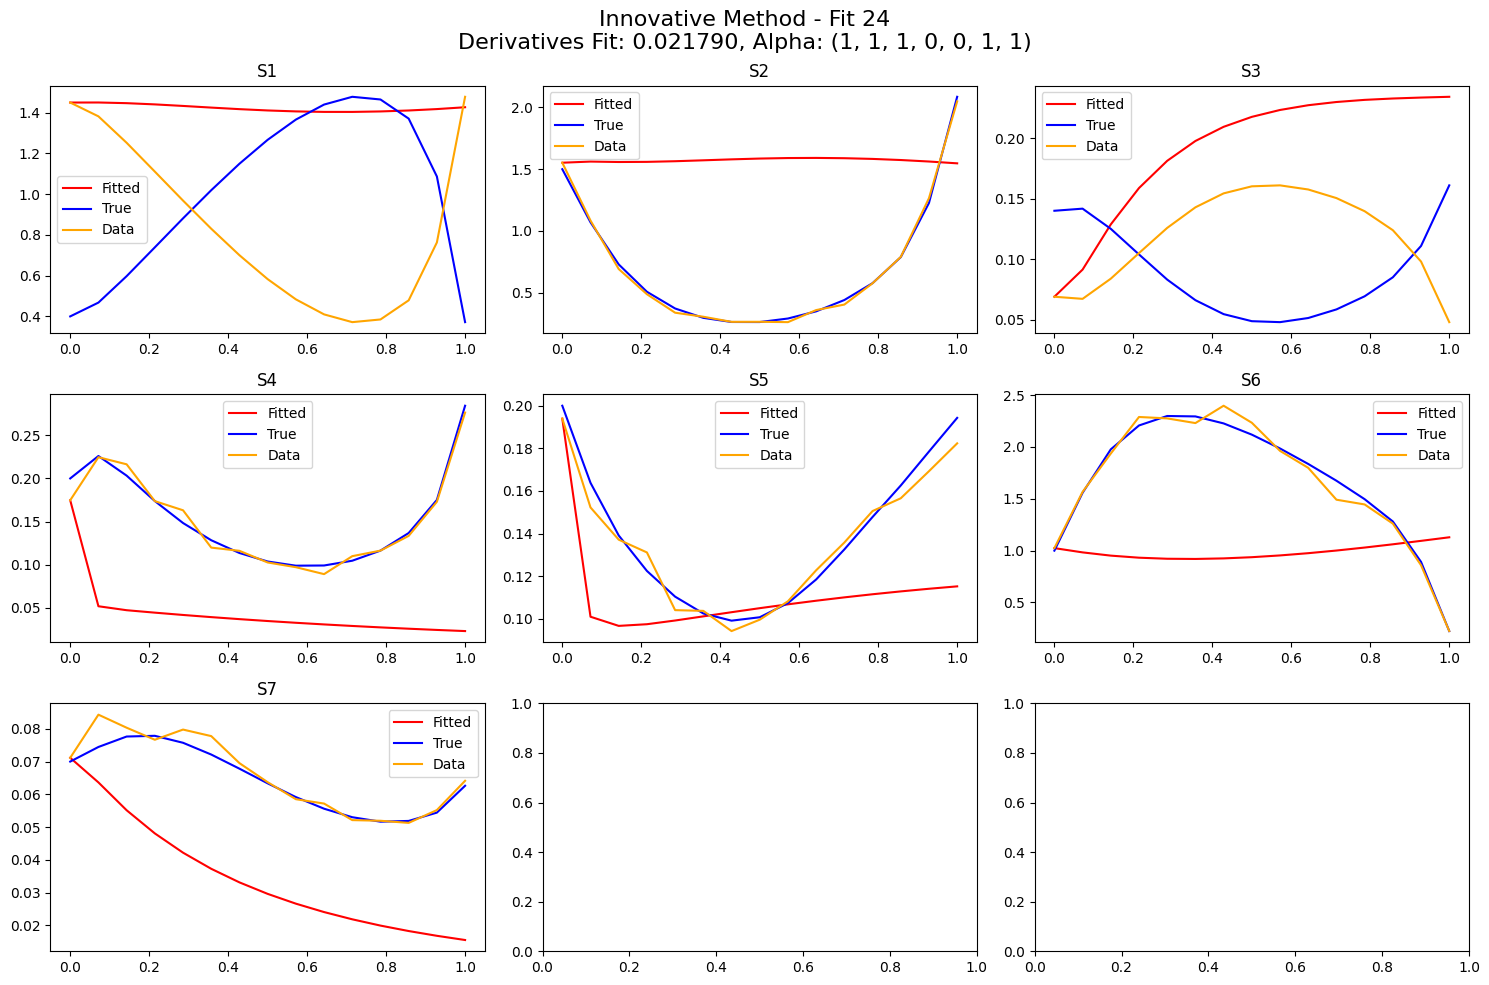

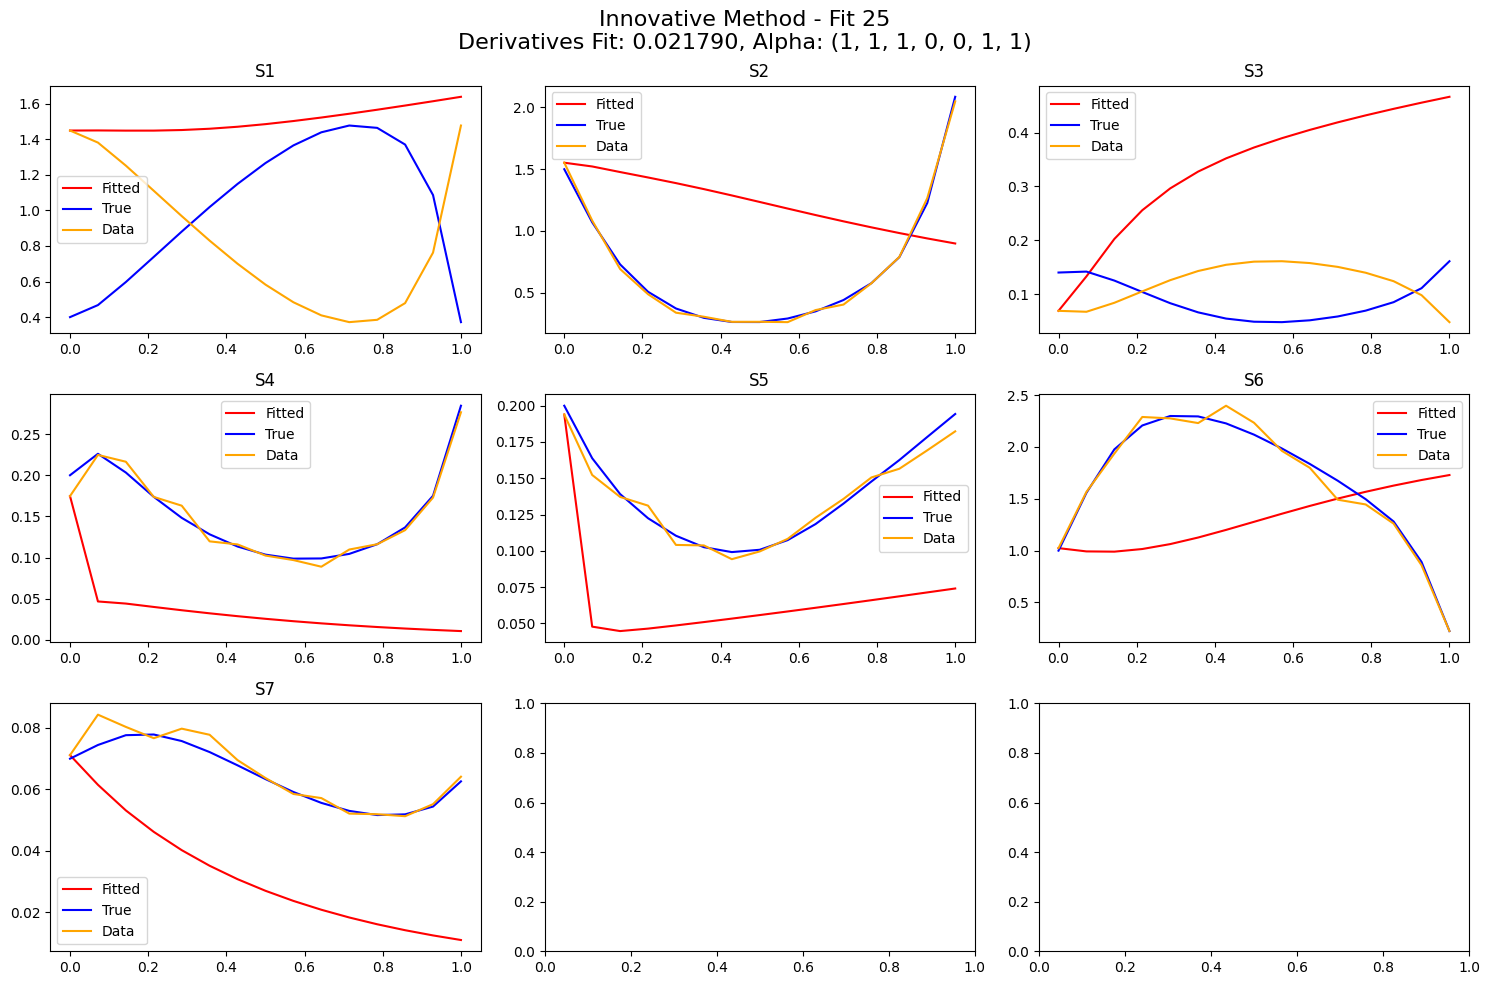

In [15]:
# [15]
# Plot the top 5 fits from innovative method
def plot_innovative_fit(result, method_name, fit_idx):
    initial_conditions = initial_conditions_innovative
    ode_params = result['parameters']

    def ode_system(t, S):
        return yeast_ode(t, S, ode_params)

    sol = solve_ivp(ode_system, [t_start, t_end], initial_conditions, t_eval=t_points, method='LSODA')
    model_solution = sol.y.T

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    axes = axes.flatten()

    for i, ax in enumerate(axes[:7]):
        ax.plot(t_points, model_solution[:, i], label='Fitted', color='red')
        ax.plot(t_points, true_solution[:, i], label='True', color='blue')
        ax.plot(t_points, data_solution[:, i], label='Data', color='orange')
        ax.set_title(variable_names[i])
        ax.legend()

    fig.suptitle(f'{method_name} - Fit {fit_idx+1}\nDerivatives Fit: {result["derivatives_fit"]:.6f}, Alpha: {result["alpha"]}', fontsize=16)
    plt.tight_layout()
    plt.show()

for idx, result in enumerate(innovative_results[:30]):
    plot_innovative_fit(result, 'Innovative Method', idx)

## Hybrid method: Using solutions from the innovative method as starting points for the classical method

In [16]:
# Hybrid method
hybrid_results = []

print("Starting Hybrid Method Optimization...")
start_time = time.time()

for (deriv_fit, alpha), param_list in sorted(beam_multimap.items())[:BEAM_TOP_K]:
    group_results = []
    for param_dict in param_list[:PICK_SIMILAR]:
        ode_params = param_dict['parameters']
        x0 = np.concatenate([initial_conditions_innovative, ode_params])

        # Create an instance of the ObjectiveFunction
        obj_func = ObjectiveFunction(yeast_ode, data_solution, t_points, num_variables=len(variable_names), lower_bounds=lower_bounds, upper_bounds=upper_bounds)

        try:
            res = minimize(obj_func, x0, method='Nelder-Mead', options={'maxiter': 20_000, 'fatol': 10e-5, 'adaptive': True}, args=(alpha,))
            result = {
                'x': res.x,
                'fun': res.fun,
                'per_variable_distances': obj_func.per_variable_distances[-1],
                'alpha': alpha,
                'initial_derivatives_fit': deriv_fit,
                'initial_fun': param_dict['fun'],
                'initial_parameters': ode_params,
                'final_parameters': res.x[len(initial_conditions_innovative):]
            }
            group_results.append(result)
            print(f"For alpha {alpha}, initial deriv_fit {deriv_fit:.6f}: Final Objective Value = {res.fun}")
        except TimeoutError:
            print(f"For alpha {alpha}, initial deriv_fit {deriv_fit:.6f}: Timeout")
            last_observed_minimum = obj_func.func_values[-1] if obj_func.func_values else np.inf
            result = {
                'x': x0,
                'fun': last_observed_minimum,
                'per_variable_distances': obj_func.per_variable_distances[-1] if obj_func.per_variable_distances else [np.inf] * len(variable_names),
                'alpha': alpha,
                'initial_derivatives_fit': deriv_fit,
                'initial_fun': param_dict['fun'],
                'initial_parameters': ode_params,
                'final_parameters': x0[len(initial_conditions_innovative):]
            }
            group_results.append(result)

    hybrid_results.extend(group_results)

end_time = time.time()
hybrid_method_time = (end_time - start_time) / 60
print(f"Hybrid Method Optimization Completed in {hybrid_method_time:.2f} minutes.")

Starting Hybrid Method Optimization...
For alpha (0, 1, 1, 1, 0, 1, 1), initial deriv_fit 0.018850: Final Objective Value = 0.0021672906020607074
For alpha (0, 1, 1, 1, 0, 1, 1), initial deriv_fit 0.018850: Final Objective Value = 0.0061197968010847
For alpha (0, 1, 1, 1, 0, 1, 1), initial deriv_fit 0.018850: Final Objective Value = 0.006198059090016543
For alpha (0, 1, 1, 1, 0, 1, 1), initial deriv_fit 0.018850: Final Objective Value = 0.035634122542688114
For alpha (0, 1, 1, 1, 0, 1, 1), initial deriv_fit 0.018850: Final Objective Value = 0.006229911328400477
For alpha (0, 1, 1, 1, 1, 0, 1), initial deriv_fit 0.020780: Final Objective Value = 0.0041420656676623355
For alpha (0, 1, 1, 1, 1, 0, 1), initial deriv_fit 0.020780: Final Objective Value = 0.004134790395083654
For alpha (0, 1, 1, 1, 1, 0, 1), initial deriv_fit 0.020780: Final Objective Value = 0.018198500581987846
For alpha (0, 1, 1, 1, 1, 0, 1), initial deriv_fit 0.020780: Final Objective Value = 0.004170011245572551
For alp

In [30]:

# Calculate the 10th percentile of all fun values
all_fun_values = [result['fun'] for result in hybrid_results]
percentile_10 = np.percentile(all_fun_values, 10)

# Group results by (deriv_fit, alpha) and calculate group scores
grouped_results = defaultdict(list)
for result in hybrid_results:
    key = (result['initial_derivatives_fit'], tuple(result['alpha']))
    grouped_results[key].append(result)

for key, group in grouped_results.items():
    total_in_group = len(group)
    smallest_in_group = sum(1 for result in group if result['fun'] <= percentile_10)
    group_score = smallest_in_group / total_in_group
    for result in group:
        result['group_score'] = group_score
        result['group_size'] = total_in_group
        result['smallest_in_group'] = smallest_in_group

# Sort hybrid_results first by group score (descending), then by individual fun value
hybrid_results.sort(key=lambda x: (-x['group_score'], x['fun']))

hybrid_results.sort(key=lambda x: (x['fun']))

In [31]:
# Output the results of the hybrid method
hybrid_df = pd.DataFrame(hybrid_results)
print("Results from Hybrid Method:")
display(hybrid_df)

Results from Hybrid Method:


x       fun  \
0   [0.06865223077764071, 0.27418191179991963, 0.0...  0.002167   
1   [0.04538260732518312, 0.1500005971589296, 0.04...  0.002728   
2   [0.0400115339367788, 0.15000063198452437, 0.04...  0.002937   
3   [0.0967695520435458, 0.18323287870134725, 0.10...  0.004098   
4   [1.5865377774955287, 0.2628400176355003, 0.069...  0.004135   
5   [1.5776303614025835, 0.2584770126973064, 0.073...  0.004142   
6   [2.216315308766131, 0.2514688867011337, 0.0728...  0.004170   
7   [0.5624838372345063, 0.4835004864907052, 0.068...  0.004893   
8   [0.5923970376300147, 0.3920615668984455, 0.068...  0.004915   
9   [0.47286870976461515, 0.5941350478886009, 0.06...  0.004960   
10  [0.705419294123149, 0.3723124381005124, 0.0686...  0.004999   
11  [0.6801559611679475, 0.4361116956302354, 0.071...  0.005018   
12  [0.6370465730444361, 0.1783796036828129, 0.044...  0.005840   
13  [2.1297600176354567, 0.15000011869789504, 0.01...  0.005943   
14  [1.479684028924694, 0.15000446771077477, 0.070...  0.006098   
15  [1.6641992810994755, 0.15157908968957168, 0.06...  0.006103   
16  [0.48823961124393933, 0.17580806505843646, 0.0...  0.006120   
17  [1.5644189440693956, 0.15361846597519183, 0.06...  0.006198   
18  [1.2623706215786443, 0.32121955869206875, 0.06...  0.006230   
19  [1.3549203297393926, 0.29959256021553105, 0.06...  0.006334   
20  [1.6384521945669257, 0.2064561355797792, 0.069...  0.006371   
21  [1.9030944250957011, 0.18784831988727282, 0.06...  0.006460   
22  [1.8190868211674776, 0.717914545932249, 0.0387...  0.006509   
23  [1.4488712795946805, 1.5526274092436252, 0.068...  0.018199   
24  [1.4488712795946805, 1.5526274092436252, 0.068...  0.035634   

                               per_variable_distances                  alpha  \
0   [0, 0.0007070892561625756, 0.00018270689932435...  (0, 1, 1, 1, 0, 1, 1)   
1   [0, 0.0008241871050006184, 0.00034267667307204...  (0, 1, 1, 0, 1, 1, 1)   
2   [0, 0.0008040985285539091, 0.00026570089957497...  (0, 1, 1, 0, 1, 1, 1)   
3   [0, 0.0007484180616934477, 0, 0.00067989447225...  (0, 1, 0, 1, 1, 1, 1)   
4   [0, 0.0009477230546662432, 0.00106033326843109...  (0, 1, 1, 1, 1, 0, 1)   
5   [0, 0.0009510372689930203, 0.00109921347710300...  (0, 1, 1, 1, 1, 0, 1)   
6   [0, 0.0009497679381409831, 0.00107704984679816...  (0, 1, 1, 1, 1, 0, 1)   
7   [0.0013995584020125968, 0.000979777638288343, ...  (1, 1, 1, 0, 0, 1, 1)   
8   [0.001351748888768209, 0.0009720680800521138, ...  (1, 1, 1, 0, 0, 1, 1)   
9   [0.0015082030066845998, 0.000983769610283233, ...  (1, 1, 1, 0, 0, 1, 1)   
10  [0.0013348345458846773, 0.000983979805637821, ...  (1, 1, 1, 0, 0, 1, 1)   
11  [0.0013570816425238852, 0.0009940090848316653,...  (1, 1, 1, 0, 0, 1, 1)   
12  [0, 0.0009640143240059546, 0, 0.00087870768410...  (0, 1, 0, 1, 1, 1, 1)   
13  [0, 0.0009673277470552911, 0, 0.00091045430862...  (0, 1, 0, 1, 1, 1, 1)   
14  [0, 0.0010092116313533282, 0, 0.00078803100951...  (0, 1, 0, 1, 1, 1, 1)   
15  [0, 0.0010016341208792029, 0, 0.00076951493422...  (0, 1, 0, 1, 1, 1, 1)   
16  [0, 0.0009510375333324717, 0.00097937235143876...  (0, 1, 1, 1, 0, 1, 1)   
17  [0, 0.0009722476977059985, 0.00099729730322025...  (0, 1, 1, 1, 0, 1, 1)   
18  [0, 0.0009551231955830245, 0.00100054358965859...  (0, 1, 1, 1, 0, 1, 1)   
19  [0, 0.0009536730993186497, 0.00102888639834346...  (0, 1, 1, 0, 1, 1, 1)   
20  [0, 0.000991157498554315, 0.001077324403036073...  (0, 1, 1, 0, 1, 1, 1)   
21  [0, 0.0009998963911509152, 0.00105492653080421...  (0, 1, 1, 0, 1, 1, 1)   
22  [0, 0.0015240615690457933, 0.00194283303529750...  (0, 1, 1, 1, 1, 0, 1)   
23  [0, 0.004951001495170692, 0.002067346882373562...  (0, 1, 1, 1, 1, 0, 1)   
24  [0, 0.005579585960636136, 0.00154033638206299,...  (0, 1, 1, 1, 0, 1, 1)   

    initial_derivatives_fit  initial_fun  \
0                   0.01885     0.034702   
1                   0.02151     0.013869   
2                   0.02151     0.016178   
3                   0.02152     0.041723   
4       

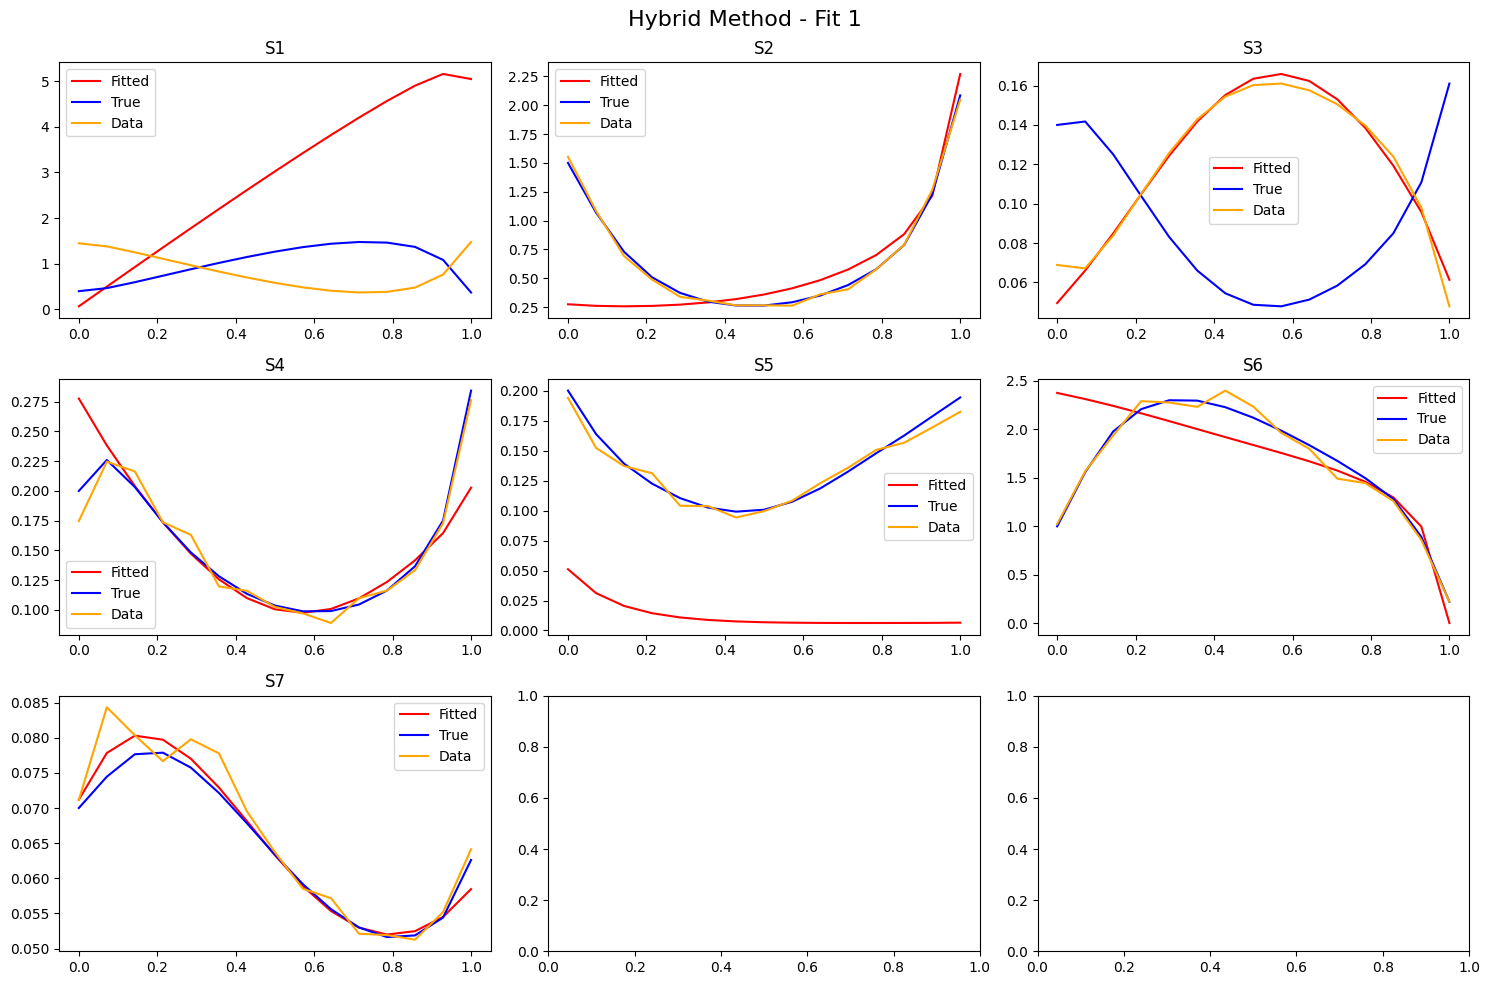

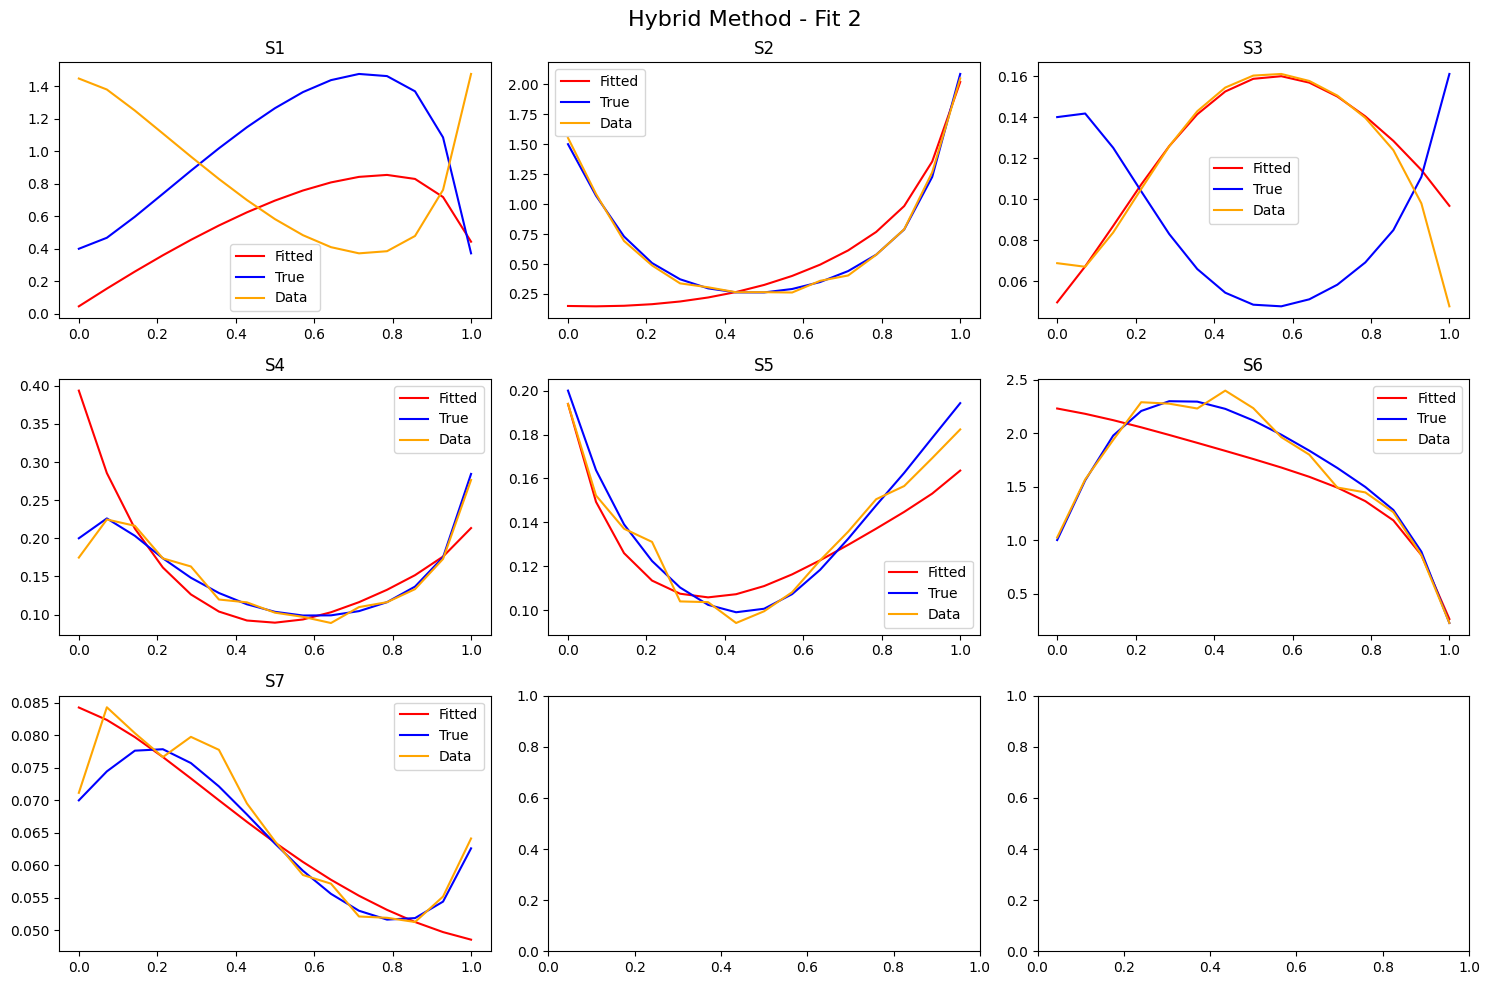

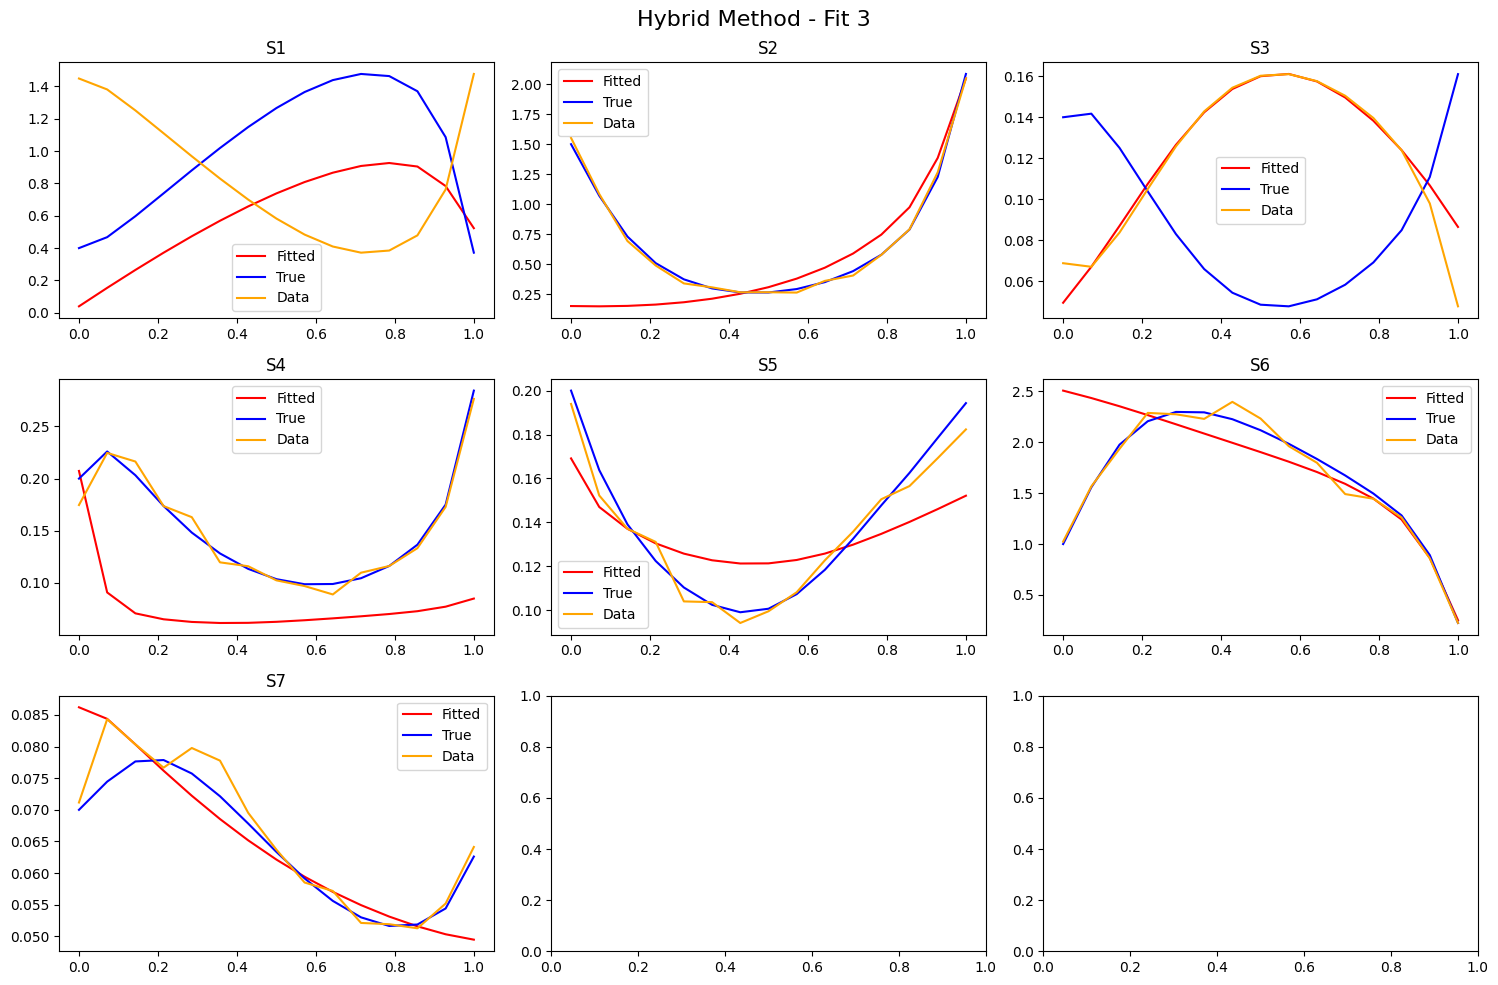

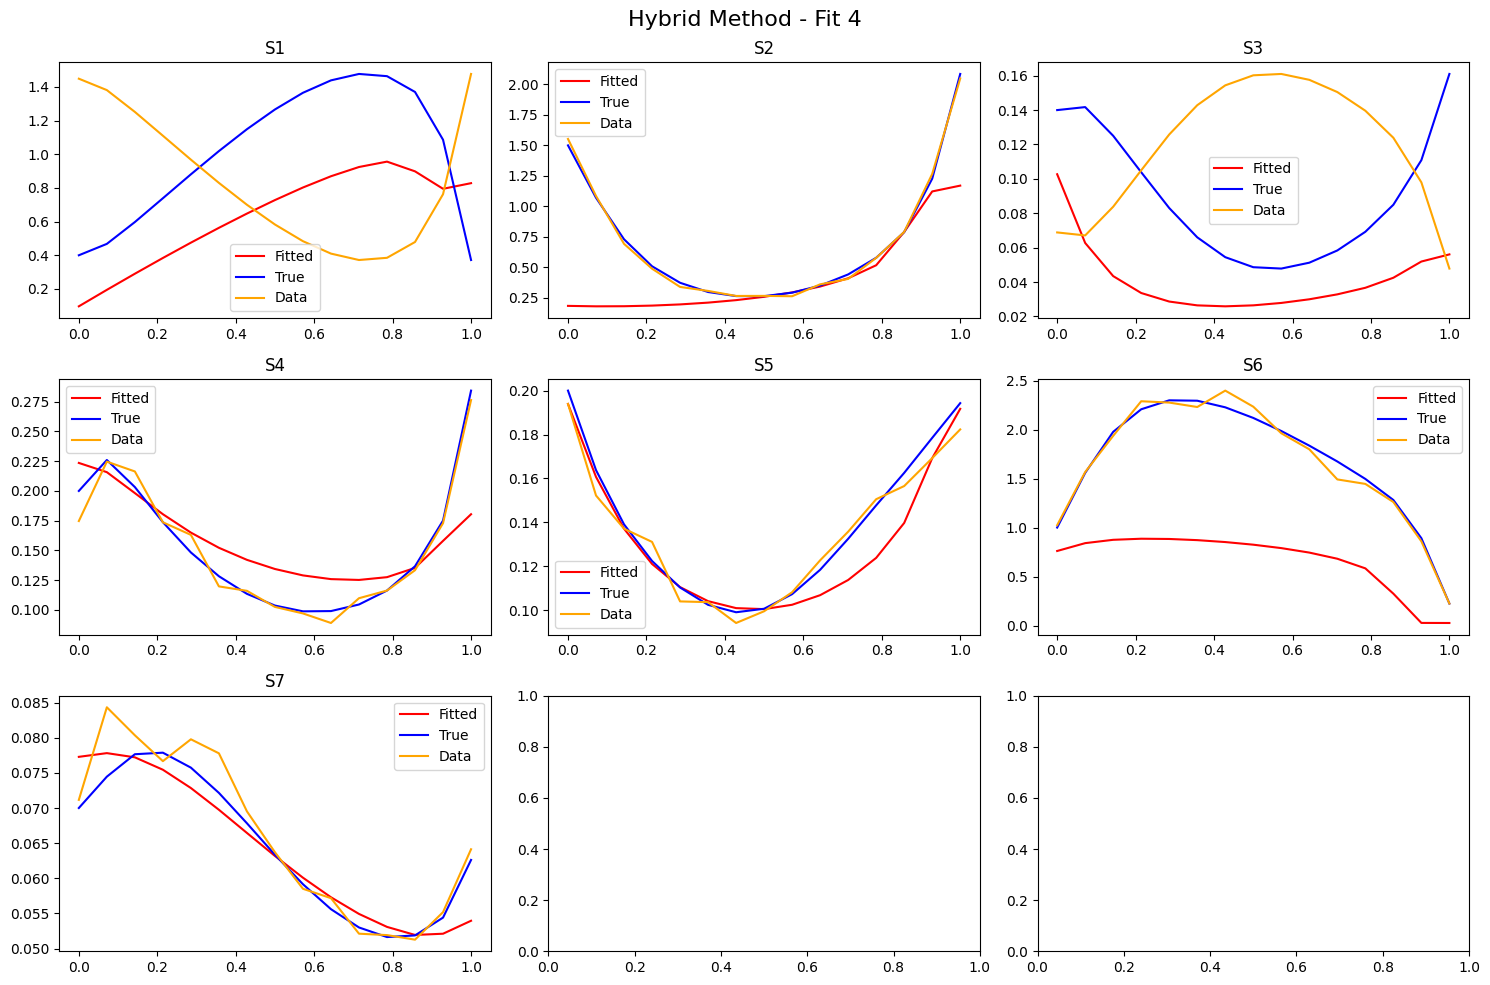

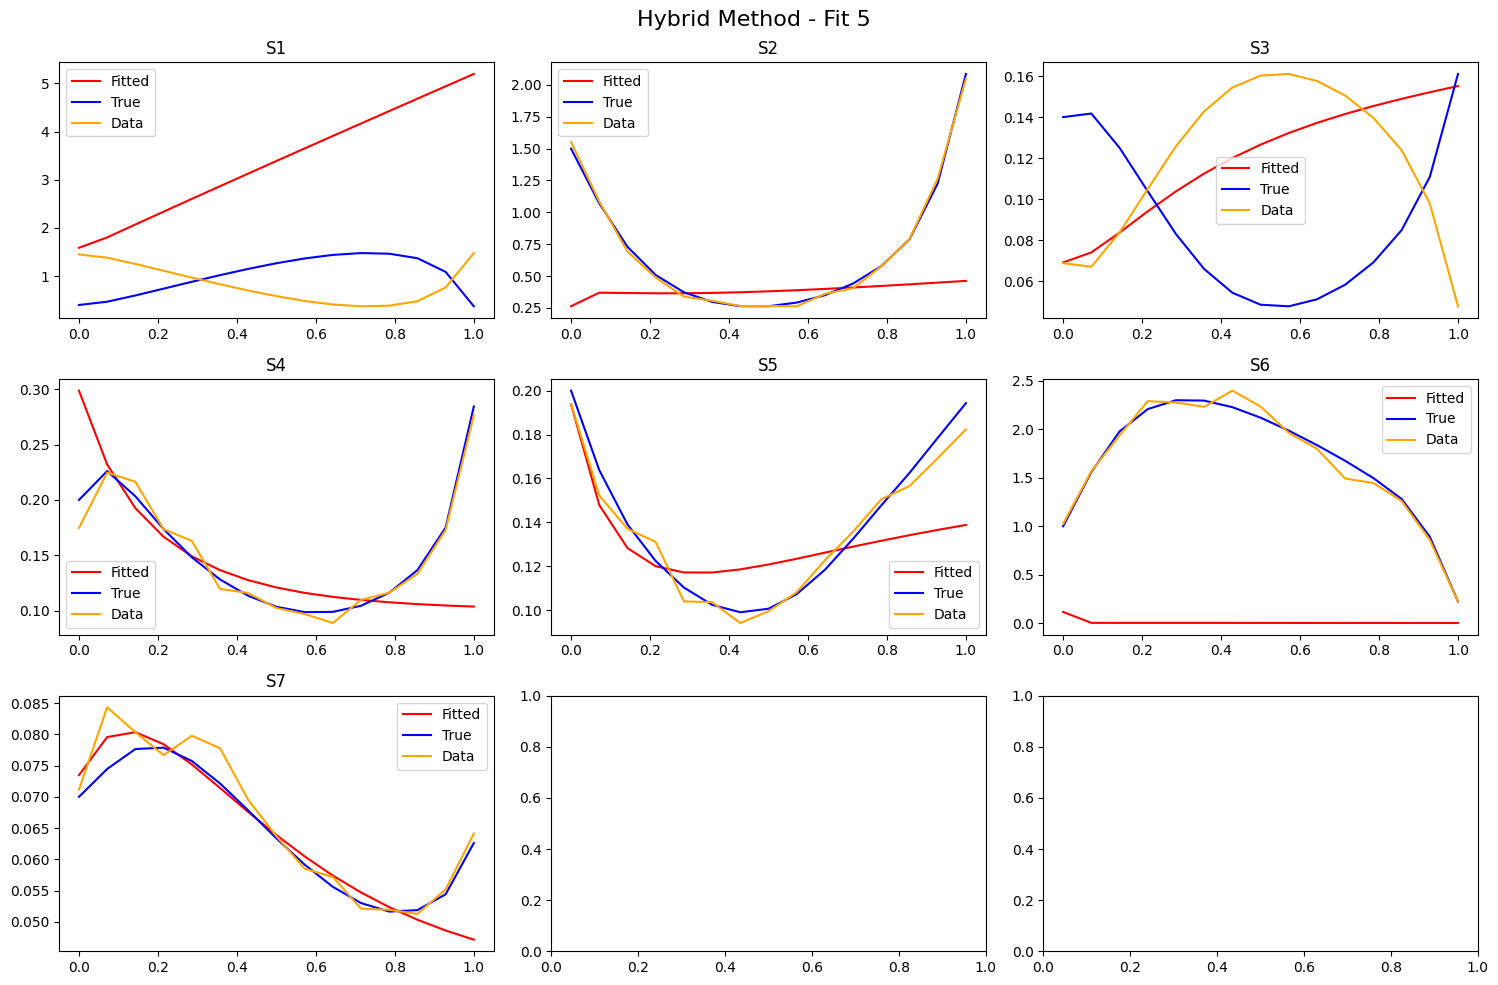

In [32]:
# Plot the top 5 fits from hybrid method
for idx, result in enumerate(hybrid_results[:5]):
    plot_fit(result, 'Hybrid Method', idx)

In [19]:
# Print total execution times for all methods
print(f"Execution Times:")
print(f"Classical Method: {classical_method_time:.2f} minutes")
print(f"Innovative Method: {innovative_method_time:.2f} minutes")
print(f"Hybrid Method: {hybrid_method_time:.2f} minutes")

Execution Times:


NameError: name 'classical_method_time' is not defined

In [ ]:
# [18]
# Display per-variable fit values for the top results
def display_top_results(sorted_results, method_name):
    df_list = []
    for idx, result in enumerate(sorted_results[:10]):
        per_variable_distances = result['per_variable_distances']
        alpha = result.get('alpha', [1] * len(variable_names))  # Default to all 1s if alpha not present
        data = {'Fit Rank': idx+1, 'Total Objective': result['fun'], 'Alpha': alpha}
        for i, var_name in enumerate(variable_names):
            data[var_name] = per_variable_distances[i]
        df_list.append(data)
    df = pd.DataFrame(df_list)
    print(f"Top 10 results for {method_name}:")
    display(df)

In [ ]:
# [19]
display_top_results(sorted_results, 'Classical Method')
display_top_results(sorted_innovative_results, 'Innovative Method')
display_top_results(sorted_hybrid_results, 'Hybrid Method')

In [ ]:
!pip install ipynbname
import json
import nbformat
from nbformat import read, write
import os
import ipynbname

def export_notebook_to_txt():
    # Get the current notebook name
    notebook_filename = ipynbname.name()
    
    # Get the full path to the notebook
    notebook_path = ipynbname.path()
    
    # Read the notebook
    with open(notebook_path, 'r', encoding='utf-8') as nb_file:
        notebook = read(nb_file, as_version=4)
    
    # Prepare content for TXT file
    notebook_content = []
    code_cell_count = 0
    for cell in notebook.cells:
        if cell.cell_type == 'code':
            code_cell_count += 1
            # cell_content = f'# [{code_cell_count}]\n'
            cell_content = cell.source
        elif cell.cell_type == 'markdown':
            cell_content = '# [MD]\n'
            cell_content += '# ' + cell.source.replace('\n', '\n# ')
        notebook_content.append(cell_content)

    # Join all cell contents
    full_content = '\n\n'.join(notebook_content)
    
    # Save to TXT file
    txt_filename = f'{notebook_filename.split(".")[0]}_content.txt'
    with open(txt_filename, 'w', encoding='utf-8') as txt_file:
        txt_file.write(full_content)

    return f"Notebook content has been exported to {txt_filename}"

# Run the function
export_notebook_to_txt()